In [1]:

%load_ext autoreload
%autoreload 2
import json, os, cv2
from pathlib import Path
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import xarray as xr
import seaborn as sns
import h5py as hf
from tqdm import tqdm
from tqdm import tqdm
import itertools 
from scipy.interpolate import interp1d
from scipy import signal
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
import os, fnmatch
from scipy.spatial.distance import cdist
import matplotlib.gridspec as gridspec
from random import sample
from scipy.ndimage import gaussian_filter1d
from matplotlib.collections import LineCollection


import sys
sys.path.insert(0, 'C:/Users/nlab/Documents/GitHub/obstacle_avoidance')

from utils.base_functions import *
from src.utils.auxiliary import flatten_series
from src.utils.path import find
from src.base import BaseInput
from plots.plots import plot_oa


import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
c:\Users\nlab\anaconda3\envs\ephys0\lib\site-packages\deeplabcut\__init__.py:78: UserWarning: 
        As PyTorch is not installed, unsupervised identity learning will not be available.
        Please run `pip install torch`, or ignore this warning.
        
  warnings.warn(


In [9]:
df = pd.read_hdf(r"D:\obstacle_avoidance\recordings\data_h5\G8CK_051023.h5")

In [5]:
import math

def calculate_speed(x_positions, y_positions, time_interval):
    speeds = []
    
    # Check if the number of positions is the same for x and y
    if len(x_positions) != len(y_positions):
        raise ValueError("The number of x and y positions must be the same.")
    
    # Iterate over the positions
    for i in range(1, len(x_positions)):
        # Calculate the change in x and y positions
        delta_x = x_positions[i] - x_positions[i-1]
        delta_y = y_positions[i] - y_positions[i-1]
        
        # Calculate the distance using Pythagorean theorem
        distance = math.sqrt(delta_x**2 + delta_y**2)
        
        # Calculate the speed by dividing distance by time
        speed = distance / time_interval
        
        speeds.append(speed)
    
    return np.array(speeds)

def plot_single_trial(df,ax,cluster):
    plot_arena(df,ax)
    plot_orginal_obstacle(df,ax,cluster)
    ax.plot(df['ts_nose_x_cm'].item(),df['ts_nose_y_cm'].item())
def get_angle_to_ports(df):

    for ind,row in df.iterrows():
        angle_to_rightport = []
        angle_to_leftport = []
        rightport = [row['rightportT_x_cm'],row['rightportT_y_cm']]
        leftport = [row['leftportT_x_cm'],row['leftportT_y_cm']]
        for indx in range(len(row['ts_nose_x_cm'])):
            center = [np.mean([row['ts_rightear_x_cm'][indx],row['ts_leftear_x_cm'][indx]]),np.mean([row['ts_rightear_y_cm'][indx],row['ts_leftear_y_cm'][indx]])]
            nose_points = [row['ts_nose_x_cm'][indx],row['ts_nose_y_cm'][indx]]
            angleright = calculate_angle(center, nose_points, rightport)
            angleleft = calculate_angle(center, nose_points, leftport)
            angle_to_rightport.append(angleright)
            angle_to_leftport.append(angleleft)
        df.at[ind,'angle_to_rightport'] = np.array(angle_to_rightport).astype(object)
        df.at[ind,'angle_to_leftport'] = np.array(angle_to_leftport).astype(object)
    right_left = ['angle_to_leftport','angle_to_rightport','ts_nose_x_cm','ts_nose_y_cm']
    for ind,row in df.iterrows():
        for direction in right_left:
            interp = pd.Series(row[direction].astype(float)).interpolate().values
            resample = signal.resample(interp,200)
            df.at[ind,'resample_'+ direction] = resample.astype(object)

def angle_to_edges(df):
    keys = list_columns(df,['obstacle'])
    keys = [key for key in keys if 'gt' in key if 'mean' not in key and 'cen' not in key and 'cm' in key] 
    corner_list = []
    for corner in keys:
        corner = corner.split('_',2)[1]
        corner_list.append(corner)
    np.unique(corner_list).tolist()
    for ind,row in df.iterrows():
        for corner in corner_list:
            angle_to = []
            position = [row['gt_' + corner + '_x_cm'],row['gt_' + corner + '_y_cm']]
            for indx in range(len(row['ts_nose_x_cm'])):
                center = [np.mean([row['ts_rightear_x_cm'][indx],row['ts_leftear_x_cm'][indx]]),np.mean([row['ts_rightear_y_cm'][indx],row['ts_leftear_y_cm'][indx]])]
                nose_points = [row['ts_nose_x_cm'][indx],row['ts_nose_y_cm'][indx]]
                angle = calculate_angle(center, nose_points, position)
                angle_to.append(angle)

            df.at[ind,'angle_to_' + corner] = np.array(angle_to).astype(object)
def speed(df):
    time = float(1/60)
    for ind, row in df.iterrows():
        speed = calculate_speed(row['ts_nose_x_cm'],row['ts_nose_y_cm'],time)
        df.at[ind,'speed'] = speed.astype(object)


In [76]:
row['mean_interp_ts_nose_x_cm']

nan

In [ ]:
 spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    """Right"""
    panel_1 = gridspec.GridSpecFromSubplotSpec(3,2,subplot_spec=spec2[0])
    ax1 = fig.add_subplot(panel_1[0,0])
    plot_arena(df,ax1)
    ax2 = fig.add_subplot(panel_1[0,1])
    plot_arena(df,ax2)
    ax2.set_title('right')
    ax3 = fig.add_subplot(panel_1[1,0])
    plot_arena(df,ax3)
    ax4 = fig.add_subplot(panel_1[1,1])
    plot_arena(df,ax4)
    ax5 = fig.add_subplot(panel_1[2,0])
    plot_arena(df,ax5)
    ax6 = fig.add_subplot(panel_1[2,1])
    plot_arena(df,ax6)
    right_axs = [ax1,ax2,ax3,ax4,ax5,ax6]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax1.legend(markers, color_map.keys(), numpoints=1,title = 'right')
    """Left """
    panel_2 = gridspec.GridSpecFromSubplotSpec(3,2,subplot_spec=spec2[1])
    ax7 = fig.add_subplot(panel_2[0,0])
    plot_arena(df,ax7)
    ax8 = fig.add_subplot(panel_2[0,1])
    plot_arena(df,ax8)
    ax8.set_title('left')
    ax9 = fig.add_subplot(panel_2[1,0])
    plot_arena(df,ax9)
    ax10 = fig.add_subplot(panel_2[1,1])
    plot_arena(df,ax10)
    ax11= fig.add_subplot(panel_2[2,0])
    plot_arena(df,ax11)
    ax12 = fig.add_subplot(panel_2[2,1])
    plot_arena(df,ax12)
    left_axs = [ax7,ax8,ax9,ax10,ax11,ax12]

In [54]:
def interp_plot(df,key,color_pallete,num_sample):

    key=key
    color_pallete = color_pallete
    color_map = create_color_dict(df,key,color_pallete)

   

    fig = plt.figure(constrained_layout=False, figsize=(20, 10),dpi=90)
    fig.suptitle('by ' + key + ' '+ 'and ' +'obstalce ')
    spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)


    """Right"""
    panel_1 = gridspec.GridSpecFromSubplotSpec(3,2,subplot_spec=spec2[0])
    ax1 = fig.add_subplot(panel_1[0,0])
    plot_arena(df,ax1)
    ax2 = fig.add_subplot(panel_1[0,1])
    plot_arena(df,ax2)
    ax2.set_title('right')
    ax3 = fig.add_subplot(panel_1[1,0])
    plot_arena(df,ax3)
    ax4 = fig.add_subplot(panel_1[1,1])
    plot_arena(df,ax4)
    ax5 = fig.add_subplot(panel_1[2,0])
    plot_arena(df,ax5)
    ax6 = fig.add_subplot(panel_1[2,1])
    plot_arena(df,ax6)

    right_axs = [ax1,ax2,ax3,ax4,ax5,ax6]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax1.legend(markers, color_map.keys(), numpoints=1,title = 'right')


    """Left """
    panel_2 = gridspec.GridSpecFromSubplotSpec(3,2,subplot_spec=spec2[1])
    ax7 = fig.add_subplot(panel_2[0,0])
    plot_arena(df,ax7)
    ax8 = fig.add_subplot(panel_2[0,1])
    plot_arena(df,ax8)
    ax8.set_title('left')
    ax9 = fig.add_subplot(panel_2[1,0])
    plot_arena(df,ax9)
    ax10 = fig.add_subplot(panel_2[1,1])
    plot_arena(df,ax10)
    ax11= fig.add_subplot(panel_2[2,0])
    plot_arena(df,ax11)
    ax12 = fig.add_subplot(panel_2[2,1])
    plot_arena(df,ax12)

    left_axs = [ax7,ax8,ax9,ax10,ax11,ax12]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax7.legend(markers, color_map.keys(), numpoints=1,title = 'left')



    """ plot trials"""
    right_obstacle_dict = dict(zip(pd.unique(df['obstacle_cluster'].sort_values().to_list()),right_axs))
    left_obstacle_dict = dict(zip(pd.unique(df['obstacle_cluster'].sort_values().to_list()),left_axs))

    for direction, direction_frame in df.groupby(['odd']):
        for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
            cluster_frame = cluster_frame.sample(num_sample)
            right_obstacle_axis = right_obstacle_dict.get(cluster)
            left_obstacle_axis = left_obstacle_dict.get(cluster)
            plot_obstacle(cluster_frame,right_obstacle_axis,cluster)
            plot_obstacle(cluster_frame,left_obstacle_axis,cluster)
            right_obstacle_axis.set_title(str(cluster))
            left_obstacle_axis.set_title(str(cluster))
            for start, start_frame in cluster_frame.groupby(['start']):
                
                if direction == 'right':
                    if start == 'top':
                        if cluster in [2,3]:
                            right_obstacle_axis.plot(np.linspace(10,50,50),start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0],c = 'black')
                            right_obstacle_axis.fill_between(np.linspace(10,50,50), start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)+start_frame['mad_interp_ts_nose_y_cm'].to_numpy()[0].astype(float), start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)-start_frame['mad_interp_ts_nose_y_cm'].to_numpy()[0].astype(float), facecolor='black', alpha=0.5)

                        else:
                            right_obstacle_axis.plot(np.linspace(10,50,50),start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0],c = 'black')
                            right_obstacle_axis.fill_between(np.linspace(10,50,50), start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)+start_frame['std_interp_ts_nose_y_cm'].to_numpy()[0].astype(float), start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)-start_frame['std_interp_ts_nose_y_cm'].to_numpy()[0].astype(float), facecolor='black', alpha=0.5)
                    if start == 'bottom':
                        if cluster in [2,3]:
                            right_obstacle_axis.plot(np.linspace(10,50,50),start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')
                            right_obstacle_axis.fill_between(np.linspace(10,50,50), start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)+start_frame['mad_interp_ts_nose_y_cm'].to_numpy()[0].astype(float), start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)-start_frame['mad_interp_ts_nose_y_cm'].to_numpy()[0].astype(float), facecolor='red', alpha=0.5)
                        else:
                            right_obstacle_axis.plot(np.linspace(10,50,50),start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')
                            right_obstacle_axis.fill_between(np.linspace(10,50,50), start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)+start_frame['std_interp_ts_nose_y_cm'].to_numpy()[0].astype(float), start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)-start_frame['std_interp_ts_nose_y_cm'].to_numpy()[0].astype(float), facecolor='red', alpha=0.5)

                
                if direction == 'left':
                    if start == 'top':
                         if cluster in [2,3]:
                            left_obstacle_axis.plot(np.linspace(10,50,50),start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0],c = 'black')
                            left_obstacle_axis.fill_between(np.linspace(10,50,50), start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)+start_frame['mad_interp_ts_nose_y_cm'].to_numpy()[0].astype(float), start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)-start_frame['mad_interp_ts_nose_y_cm'].to_numpy()[0].astype(float), facecolor='black', alpha=0.5)
                         else:
                            left_obstacle_axis.plot(np.linspace(10,50,50),start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0],c = 'black')
                            left_obstacle_axis.fill_between(np.linspace(10,50,50), start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)+start_frame['std_interp_ts_nose_y_cm'].to_numpy()[0].astype(float), start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)-start_frame['std_interp_ts_nose_y_cm'].to_numpy()[0].astype(float), facecolor='black', alpha=0.5)
                    if start == 'bottom':
                        if cluster in [2,3]:
                            left_obstacle_axis.plot(np.linspace(10,50,50),start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')
                            left_obstacle_axis.fill_between(np.linspace(10,50,50), start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)+start_frame['mad_interp_ts_nose_y_cm'].to_numpy()[0].astype(float), start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)-start_frame['mad_interp_ts_nose_y_cm'].to_numpy()[0].astype(float), facecolor='red', alpha=0.5)

                        else:
                            left_obstacle_axis.plot(np.linspace(10,50,50),start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')
                            left_obstacle_axis.fill_between(np.linspace(10,50,50), start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)+start_frame['std_interp_ts_nose_y_cm'].to_numpy()[0].astype(float), start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)-start_frame['std_interp_ts_nose_y_cm'].to_numpy()[0].astype(float), facecolor='red', alpha=0.5)

In [64]:
session.df

index    first_poke   second_poke  \
0         1  55849.980608  55854.351193   
1         3  55856.703040  55863.809664   
2         5  55873.899059  55878.777804   
3         7  55884.844595  55888.674624   
4         8  55888.674624  55892.103206   
...     ...           ...           ...   
4630    158  56997.887680  56999.653209   
4631    161  57007.452492  57009.173004   
4632    162  57009.173004  57012.446028   
4633    163  57012.446028  57013.875635   
4634    165  57019.532697  57023.674099   

                                       trial_timestamps  \
0     [55849.982899, 55850.000243, 55850.016243, 558...   
1     [55856.718592, 55856.735385, 55856.752588, 558...   
2     [55873.907904, 55873.92471, 55873.941286, 5587...   
3     [55884.845299, 55884.861926, 55884.879436, 558...   
4     [55888.68014, 55888.696358, 55888.713036, 5588...   
...                                                 ...   
4630  [56997.904038, 56997.920294, 56997.936742, 569...   
4631  [57007.457113, 57007.473484, 57007.490496, 570...   
4632  [57009.174016, 57009.191744, 57009.207398, 570...   
4633  [57012.458444, 57012.475379, 57012.492787, 570...   
4634  [57019.544294, 57019.562393, 57019.577996, 570...   

                                        trial_vidframes  \
0     [[618, 619, 620, 621, 622, 623, 624, 625, 626,...   
1     [[1022, 1023, 1024, 1025, 1026, 1027, 1028, 10...   
2     [[2053, 2054, 2055, 2056, 2057, 2058, 2059, 20...   
3     [[2709, 2710, 2711, 2712, 2713, 2714, 2715, 27...   
4     [2939, 2940, 2941, 2942, 2943, 2944, 2945, 294...   
...                                                 ...   
4630  [[36468, 36469, 36470, 36471, 36472, 36473, 36...   
4631  [37041, 37042, 37043, 37044, 37045, 37046, 370...   
4632  [[37144, 37145, 37146, 37147, 37148, 37149, 37...   
4633  [37341, 37342, 37343, 37344, 37345, 37346, 373...   
4634  [37766, 37767, 37768, 37769, 37770, 37771, 377...   

                                                 nose_x  \
0     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4     [98.96044158935547, 98.02863311767578, 98.9829...   
...                                                 ...   
4630  [684.3792724609375, nan, nan, nan, nan, nan, n...   
4631  [114.53376770019531, 114.5760269165039, 114.74...   
4632  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4633  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4634  [114.63724517822266, 115.74132537841797, 115.7...   

                                                 nose_y  \
0     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4     [278.30615234375, 278.5882568359375, 278.59121...   
...                                                 ...   
4630  [275.2332458496094, nan, nan, nan, nan, nan, n...   
4631  [275.0440979003906, 275.1921691894531, 275.514...   
4632  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4633  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4634  [276.356201171875, 277.93194580078125, 278.503...   

                                              leftear_x  \
0     [678.4732055664062, 678.5654907226562, 679.592...   
1     [681.59326171875, 682.0374755859375, 682.17260...   
2     [676.9694213867188, 677.7153930664062, 678.769...   
3     [677.1893310546875, 678.1749877929688, 679.715...   
4     [117.44532012939453, 116.13001251220703, 115.6...   
...                                                 ...   
4630  [671.2802734375, 671.4435424804688, 672.833190...   
4631  [134.59718322753906, 135.1036834716797, 134.42...   
4632  [671.7008056640625, 673.11279296875, 674.76214...   
4633  [119.08003997802734, 121.93495178222656, 121.7...   
4634

In [33]:
np.linspace(10,50,50)

array([10.        , 10.81632653, 11.63265306, 12.44897959, 13.26530612,
       14.08163265, 14.89795918, 15.71428571, 16.53061224, 17.34693878,
       18.16326531, 18.97959184, 19.79591837, 20.6122449 , 21.42857143,
       22.24489796, 23.06122449, 23.87755102, 24.69387755, 25.51020408,
       26.32653061, 27.14285714, 27.95918367, 28.7755102 , 29.59183673,
       30.40816327, 31.2244898 , 32.04081633, 32.85714286, 33.67346939,
       34.48979592, 35.30612245, 36.12244898, 36.93877551, 37.75510204,
       38.57142857, 39.3877551 , 40.20408163, 41.02040816, 41.83673469,
       42.65306122, 43.46938776, 44.28571429, 45.10204082, 45.91836735,
       46.73469388, 47.55102041, 48.36734694, 49.18367347, 50.        ])

In [32]:
Nsteps, Nwalkers = 100, 250
t = np.arange(Nsteps)
t

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [35]:
session.df['std_interp_ts_nose_y_cm'].to_numpy()[0].astype(float)

array([1.09052243, 1.3447824 , 1.64475748, 1.95993763, 2.23692372,
       2.51347308, 2.79768389, 3.05183527, 3.31014936, 3.57510108,
       3.80791382, 4.01567797, 4.21289383, 4.40011539, 4.56540165,
       4.74730474, 4.92454124, 5.10022624, 5.26466149, 5.41798995,
       5.53915952, 5.69123353, 5.79675285, 5.88305002, 5.94779177,
       5.98734931, 6.01616794, 6.01776949, 5.97933718, 5.92808827,
       5.84294309, 5.71773398, 5.56672486, 5.28893232, 5.02231156,
       4.57750203, 4.10846424, 3.63449565, 3.25202843, 3.05390955,
       2.79648057, 2.49697658, 2.23809829, 1.85750138, 1.83189312,
       1.67120575, 1.67831226, 1.72049225, 1.6626612 , 1.6651545 ])

In [31]:
session.df['mean_interp_ts_nose_y_cm'].to_numpy()[0] - session.df['std_interp_ts_nose_y_cm'].to_numpy()[0]

array([20.29447461900224, 20.033464699994596, 19.878255432824417,
       19.757110384953666, 19.687338321010674, 19.643888635794852,
       19.620175352416048, 19.61823747167001, 19.620130358813146,
       19.605735741068663, 19.631141005284043, 19.67649719711536,
       19.7335619575968, 19.801909850199138, 19.873246243814496,
       19.911838879341982, 19.949215095470343, 19.97248125696312,
       19.988060781480492, 19.999343183592497, 20.021938047240937,
       19.96719454242204, 19.999633357650744, 20.057961606361168,
       20.092573480614437, 20.1287808307344, 20.15586715212413,
       20.210606318188375, 20.256235895968626, 20.304305225401986,
       20.364941733826136, 20.44794252371037, 20.50660744608114,
       20.679086553321007, 20.822007549200336, 21.150790693357166,
       21.643974288989178, 22.123142344903815, 22.496365363861837,
       22.561766586063502, 22.788243320238465, 23.00638686393323,
       23.209106048200915, 23.56701212819065, 23.45081809479112,
       23.

In [61]:
session = plot_oa(r"D:\obstacle_avoidance\metadata\G8CK\G8CK_oa_042823_050323.json",'blank')
session.gather_session_df('obstacle',6)

6


In [62]:
session.df

index    first_poke   second_poke  \
0         1  55849.980608  55854.351193   
1         3  55856.703040  55863.809664   
2         5  55873.899059  55878.777804   
3         7  55884.844595  55888.674624   
4         8  55888.674624  55892.103206   
...     ...           ...           ...   
4630    158  56997.887680  56999.653209   
4631    161  57007.452492  57009.173004   
4632    162  57009.173004  57012.446028   
4633    163  57012.446028  57013.875635   
4634    165  57019.532697  57023.674099   

                                       trial_timestamps  \
0     [55849.982899, 55850.000243, 55850.016243, 558...   
1     [55856.718592, 55856.735385, 55856.752588, 558...   
2     [55873.907904, 55873.92471, 55873.941286, 5587...   
3     [55884.845299, 55884.861926, 55884.879436, 558...   
4     [55888.68014, 55888.696358, 55888.713036, 5588...   
...                                                 ...   
4630  [56997.904038, 56997.920294, 56997.936742, 569...   
4631  [57007.457113, 57007.473484, 57007.490496, 570...   
4632  [57009.174016, 57009.191744, 57009.207398, 570...   
4633  [57012.458444, 57012.475379, 57012.492787, 570...   
4634  [57019.544294, 57019.562393, 57019.577996, 570...   

                                        trial_vidframes  \
0     [[618, 619, 620, 621, 622, 623, 624, 625, 626,...   
1     [[1022, 1023, 1024, 1025, 1026, 1027, 1028, 10...   
2     [[2053, 2054, 2055, 2056, 2057, 2058, 2059, 20...   
3     [[2709, 2710, 2711, 2712, 2713, 2714, 2715, 27...   
4     [2939, 2940, 2941, 2942, 2943, 2944, 2945, 294...   
...                                                 ...   
4630  [[36468, 36469, 36470, 36471, 36472, 36473, 36...   
4631  [37041, 37042, 37043, 37044, 37045, 37046, 370...   
4632  [[37144, 37145, 37146, 37147, 37148, 37149, 37...   
4633  [37341, 37342, 37343, 37344, 37345, 37346, 373...   
4634  [37766, 37767, 37768, 37769, 37770, 37771, 377...   

                                                 nose_x  \
0     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4     [98.96044158935547, 98.02863311767578, 98.9829...   
...                                                 ...   
4630  [684.3792724609375, nan, nan, nan, nan, nan, n...   
4631  [114.53376770019531, 114.5760269165039, 114.74...   
4632  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4633  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4634  [114.63724517822266, 115.74132537841797, 115.7...   

                                                 nose_y  \
0     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4     [278.30615234375, 278.5882568359375, 278.59121...   
...                                                 ...   
4630  [275.2332458496094, nan, nan, nan, nan, nan, n...   
4631  [275.0440979003906, 275.1921691894531, 275.514...   
4632  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4633  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4634  [276.356201171875, 277.93194580078125, 278.503...   

                                              leftear_x  \
0     [678.4732055664062, 678.5654907226562, 679.592...   
1     [681.59326171875, 682.0374755859375, 682.17260...   
2     [676.9694213867188, 677.7153930664062, 678.769...   
3     [677.1893310546875, 678.1749877929688, 679.715...   
4     [117.44532012939453, 116.13001251220703, 115.6...   
...                                                 ...   
4630  [671.2802734375, 671.4435424804688, 672.833190...   
4631  [134.59718322753906, 135.1036834716797, 134.42...   
4632  [671.7008056640625, 673.11279296875, 674.76214...   
4633  [119.08003997802734, 121.93495178222656, 121.7...   
4634

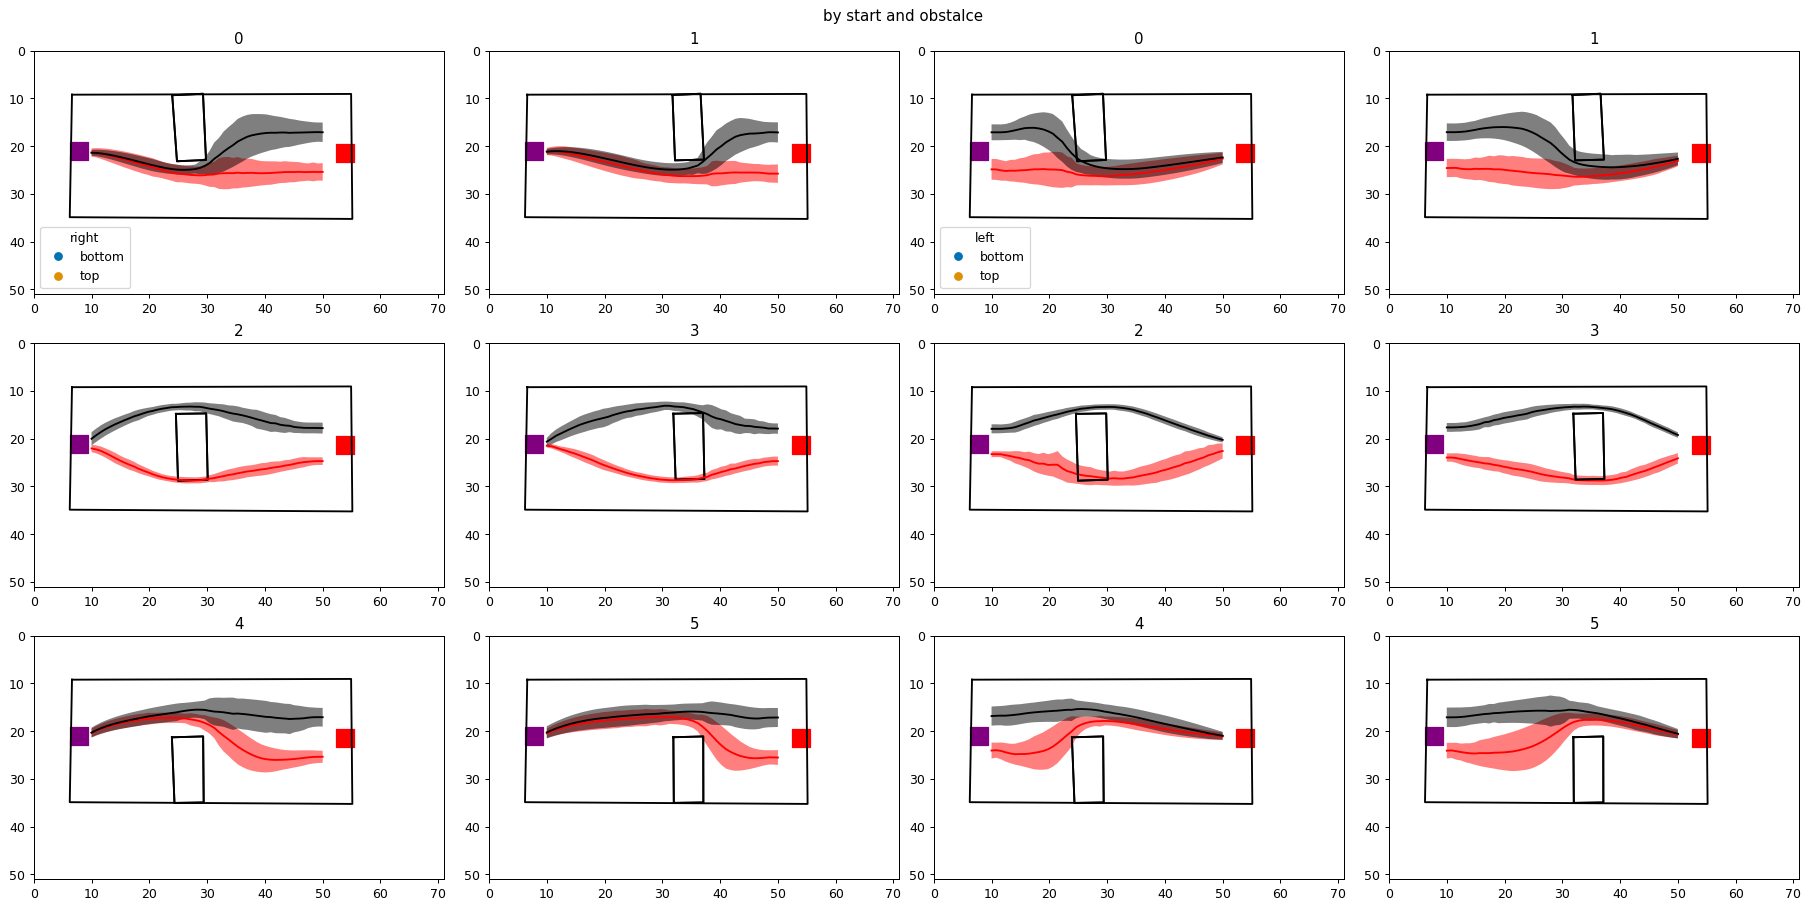

In [55]:
interp_plot(session.df,'start','colorblind',100)

In [547]:
def date_obstacle_by_variable(df,key,color_pallete,num_sample):
    """Direction by key obstalce trials"""
    x_basis = np.linspace(10,50,50)
    #savepath = "D:/obstacle_avoidance/recordings"
    #savepath_session = os.path.join(*[savepath,'figures'])
    key=key
    color_pallete = color_pallete
    color_map = create_color_dict(df,key,color_pallete)
    #pdf = PdfPages(os.path.join((savepath_session), 'by ' + str(key)+ ' '+ 'and ' +' obstalce.pdf'))
    fig = plt.figure(constrained_layout=False, figsize=(20, 10),dpi=90)

    
    fig.suptitle('by ' + key + ' '+ 'and ' +'obstalce ')
    spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    """Right"""
    panel_1 = gridspec.GridSpecFromSubplotSpec(3,2,subplot_spec=spec2[0])
    ax1 = fig.add_subplot(panel_1[0,0])
    plot_arena(df,ax1)
    ax2 = fig.add_subplot(panel_1[0,1])
    plot_arena(df,ax2)
    ax2.set_title('right')
    ax3 = fig.add_subplot(panel_1[1,0])
    plot_arena(df,ax3)
    ax4 = fig.add_subplot(panel_1[1,1])
    plot_arena(df,ax4)
    ax5 = fig.add_subplot(panel_1[2,0])
    plot_arena(df,ax5)
    ax6 = fig.add_subplot(panel_1[2,1])
    plot_arena(df,ax6)
    right_axs = [ax1,ax2,ax3,ax4,ax5,ax6]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax1.legend(markers, color_map.keys(), numpoints=1,title = 'right')
    """Left """
    panel_2 = gridspec.GridSpecFromSubplotSpec(3,2,subplot_spec=spec2[1])
    ax7 = fig.add_subplot(panel_2[0,0])
    plot_arena(df,ax7)
    ax8 = fig.add_subplot(panel_2[0,1])
    plot_arena(df,ax8)
    ax8.set_title('left')
    ax9 = fig.add_subplot(panel_2[1,0])
    plot_arena(df,ax9)
    ax10 = fig.add_subplot(panel_2[1,1])
    plot_arena(df,ax10)
    ax11= fig.add_subplot(panel_2[2,0])
    plot_arena(df,ax11)
    ax12 = fig.add_subplot(panel_2[2,1])
    plot_arena(df,ax12)
    left_axs = [ax7,ax8,ax9,ax10,ax11,ax12]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax7.legend(markers, color_map.keys(), numpoints=1,title = 'left')
    """ plot trials"""
    right_obstacle_dict = dict(zip(pd.unique(df['obstacle_cluster'].sort_values().to_list()),right_axs))
    left_obstacle_dict = dict(zip(pd.unique(df['obstacle_cluster'].sort_values().to_list()),left_axs))
    for direction, direction_frame in df.groupby(['odd']):
        for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
            #cluster_frame = cluster_frame.sample(num_sample)
            right_obstacle_axis = right_obstacle_dict.get(cluster)
            left_obstalce_axis = left_obstacle_dict.get(cluster)
            plot_obstacle(cluster_frame,right_obstacle_axis,cluster)
            plot_obstacle(cluster_frame,left_obstalce_axis,cluster)
            right_obstacle_axis.set_title(str(cluster))
            left_obstalce_axis.set_title(str(cluster))
            for ind,row in cluster_frame.iterrows():
                #print(key)
                #print(ind)
                color = color_map.get(pd.unique(row[key]).item())
                if direction == 'right':
                    which_axis = right_obstacle_dict.get(cluster)
                    which_axis.plot(x_basis,row['interp_ts_nose_y_cm'],c = color,)
                if direction == 'left':
                    which_axis = left_obstacle_dict.get(cluster)
                    which_axis.plot(x_basis,row['interp_ts_nose_y_cm'],c = color)
            for start, start_frame in cluster_frame.groupby(['start']):
                    
                    if direction == 'right':
                        if start == 'top':
                            if cluster in [2,3]:
                                 right_obstacle_axis.plot(x_basis,start_frame['date_median_interp_ts_nose_y_cm'].to_numpy()[0],c = 'black')
                            else:
                                right_obstacle_axis.plot(x_basis,start_frame['date_mean_interp_ts_nose_y_cm'].to_numpy()[0],c = 'black')
                            #right_obstacle_axis.plot(start_frame['mean_interp_ts_nose_x_cm'].to_numpy()[0],start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')
                        if start == 'bottom':
                            if cluster in [2,3]:
                                right_obstacle_axis.plot(x_basis,start_frame['date_median_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')
                            else:
                                right_obstacle_axis.plot(x_basis,start_frame['date_mean_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')
    
                    
                    if direction == 'left':
                        if start == 'top':
                            if cluster in [2,3]:
                                left_obstalce_axis.plot(x_basis,start_frame['date_median_interp_ts_nose_y_cm'].to_numpy()[0],c = 'black')
                            else:
                                left_obstalce_axis.plot(x_basis,start_frame['date_mean_interp_ts_nose_y_cm'].to_numpy()[0],c = 'black')
                        if start == 'bottom':
                             if cluster in [2,3]:
                                left_obstalce_axis.plot(x_basis,start_frame['date_median_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')
                             else:
                                left_obstalce_axis.plot(x_basis,start_frame['date_mean_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')
    #pdf.savefig(); plt.close()
    #pdf.close()


In [655]:
def figure_setup(df,key,color_pallete):
    """Direction by key obstalce trials"""
    x_basis = np.linspace(10,50,50)
    #savepath = "D:/obstacle_avoidance/recordings"
    #savepath_session = os.path.join(*[savepath,'figures'])
    key=key
    color_pallete = color_pallete
    color_map = create_color_dict(df,key,color_pallete)
    #pdf = PdfPages(os.path.join((savepath_session), 'by ' + str(key)+ ' '+ 'and ' +' obstalce.pdf'))
    fig = plt.figure(constrained_layout=False, figsize=(20, 10),dpi=90)

    
    #fig.suptitle(df['exp'].to_numpy()[0] + '_by ' + key + ' '+ 'and ' +'obstalce ')
    spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    """Right"""
    panel_1 = gridspec.GridSpecFromSubplotSpec(3,2,subplot_spec=spec2[0])
    ax1 = fig.add_subplot(panel_1[0,0])
    plot_arena(df,ax1)
    ax2 = fig.add_subplot(panel_1[0,1])
    plot_arena(df,ax2)
    ax2.set_title('right')
    ax3 = fig.add_subplot(panel_1[1,0])
    plot_arena(df,ax3)
    ax4 = fig.add_subplot(panel_1[1,1])
    plot_arena(df,ax4)
    ax5 = fig.add_subplot(panel_1[2,0])
    plot_arena(df,ax5)
    ax6 = fig.add_subplot(panel_1[2,1])
    plot_arena(df,ax6)
    right_axs = [ax1,ax2,ax3,ax4,ax5,ax6]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax1.legend(markers, color_map.keys(), numpoints=1,title = 'right')
    """Left """
    panel_2 = gridspec.GridSpecFromSubplotSpec(3,2,subplot_spec=spec2[1])
    ax7 = fig.add_subplot(panel_2[0,0])
    plot_arena(df,ax7)
    ax8 = fig.add_subplot(panel_2[0,1])
    plot_arena(df,ax8)
    ax8.set_title('left')
    ax9 = fig.add_subplot(panel_2[1,0])
    plot_arena(df,ax9)
    ax10 = fig.add_subplot(panel_2[1,1])
    plot_arena(df,ax10)
    ax11= fig.add_subplot(panel_2[2,0])
    plot_arena(df,ax11)
    ax12 = fig.add_subplot(panel_2[2,1])
    plot_arena(df,ax12)
    left_axs = [ax7,ax8,ax9,ax10,ax11,ax12]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax7.legend(markers, color_map.keys(), numpoints=1,title = 'left')
    """ plot trials"""
    right_obstacle_dict = dict(zip(pd.unique(df['obstacle_cluster'].sort_values().to_list()),right_axs))
    left_obstacle_dict = dict(zip(pd.unique(df['obstacle_cluster'].sort_values().to_list()),left_axs))
    for direction, direction_frame in df.groupby(['odd']):
        for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
            #cluster_frame = cluster_frame.sample(num_sample)
            right_obstacle_axis = right_obstacle_dict.get(cluster)
            left_obstalce_axis = left_obstacle_dict.get(cluster)
            #plot_obstacle(cluster_frame,right_obstacle_axis,cluster)
            #plot_obstacle(cluster_frame,left_obstalce_axis,cluster)
            right_obstacle_axis.set_title(str(cluster))
            left_obstalce_axis.set_title(str(cluster))

            plot_obstacle(cluster_frame,right_obstacle_axis,cluster)
            plot_obstacle(cluster_frame,left_obstalce_axis,cluster)
    return color_map,right_obstacle_dict,left_obstacle_dict,fig
        
            

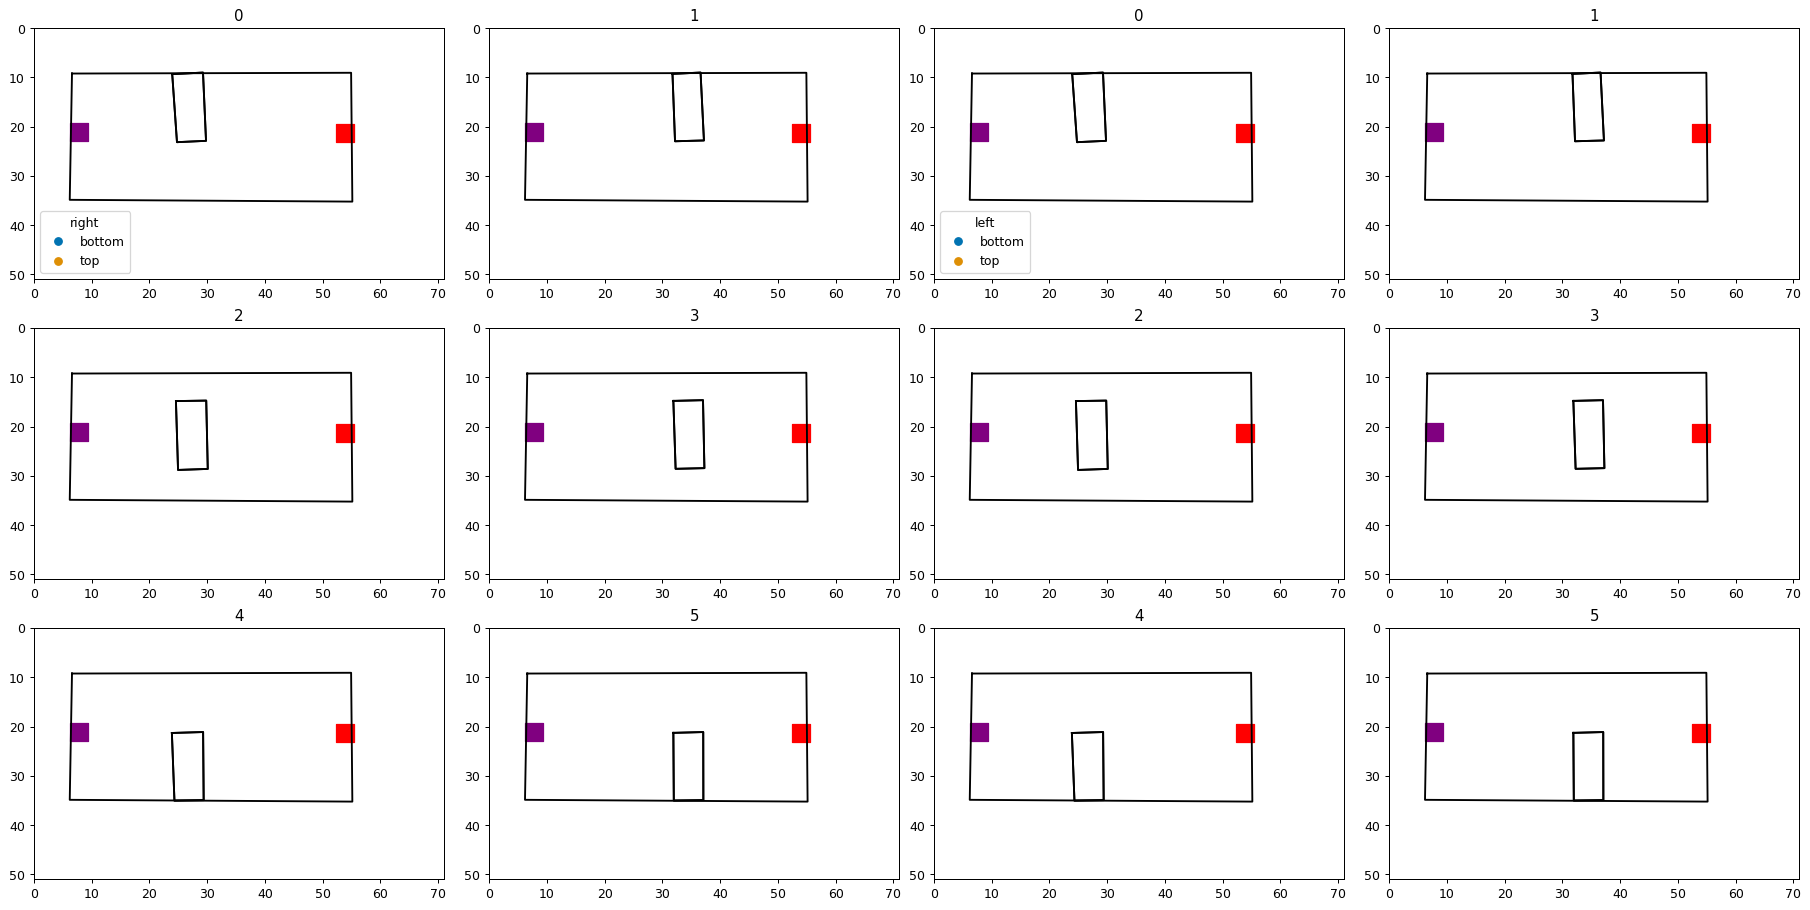

In [656]:
color_map,right_obstacle_dict,left_obstacle_dict,fig = figure_setup(session.df,'start','colorblind')
ax1.plot(1,2)

In [658]:
fig.axes

[<AxesSubplot: title={'center': '0'}>,
 <AxesSubplot: title={'center': '1'}>,
 <AxesSubplot: title={'center': '2'}>,
 <AxesSubplot: title={'center': '3'}>,
 <AxesSubplot: title={'center': '4'}>,
 <AxesSubplot: title={'center': '5'}>,
 <AxesSubplot: title={'center': '0'}>,
 <AxesSubplot: title={'center': '1'}>,
 <AxesSubplot: title={'center': '2'}>,
 <AxesSubplot: title={'center': '3'}>,
 <AxesSubplot: title={'center': '4'}>,
 <AxesSubplot: title={'center': '5'}>]

In [645]:
def obstacle_by_variable(df,key,color_pallete,num_sample):
    """Direction by key obstalce trials"""
    x_basis = np.linspace(10,50,50)
    #savepath = "D:/obstacle_avoidance/recordings"
    #savepath_session = os.path.join(*[savepath,'figures'])
    key=key
    color_pallete = color_pallete
    color_map = create_color_dict(df,key,color_pallete)
    #pdf = PdfPages(os.path.join((savepath_session), 'by ' + str(key)+ ' '+ 'and ' +' obstalce.pdf'))
    fig = plt.figure(constrained_layout=False, figsize=(20, 10),dpi=90)

    
    fig.suptitle(df['exp'].to_numpy()[0] + '_by ' + key + ' '+ 'and ' +'obstalce ')
    spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    """Right"""
    panel_1 = gridspec.GridSpecFromSubplotSpec(3,2,subplot_spec=spec2[0])
    ax1 = fig.add_subplot(panel_1[0,0])
    plot_arena(df,ax1)
    ax2 = fig.add_subplot(panel_1[0,1])
    plot_arena(df,ax2)
    ax2.set_title('right')
    ax3 = fig.add_subplot(panel_1[1,0])
    plot_arena(df,ax3)
    ax4 = fig.add_subplot(panel_1[1,1])
    plot_arena(df,ax4)
    ax5 = fig.add_subplot(panel_1[2,0])
    plot_arena(df,ax5)
    ax6 = fig.add_subplot(panel_1[2,1])
    plot_arena(df,ax6)
    right_axs = [ax1,ax2,ax3,ax4,ax5,ax6]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax1.legend(markers, color_map.keys(), numpoints=1,title = 'right')
    """Left """
    panel_2 = gridspec.GridSpecFromSubplotSpec(3,2,subplot_spec=spec2[1])
    ax7 = fig.add_subplot(panel_2[0,0])
    plot_arena(df,ax7)
    ax8 = fig.add_subplot(panel_2[0,1])
    plot_arena(df,ax8)
    ax8.set_title('left')
    ax9 = fig.add_subplot(panel_2[1,0])
    plot_arena(df,ax9)
    ax10 = fig.add_subplot(panel_2[1,1])
    plot_arena(df,ax10)
    ax11= fig.add_subplot(panel_2[2,0])
    plot_arena(df,ax11)
    ax12 = fig.add_subplot(panel_2[2,1])
    plot_arena(df,ax12)
    left_axs = [ax7,ax8,ax9,ax10,ax11,ax12]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax7.legend(markers, color_map.keys(), numpoints=1,title = 'left')
    """ plot trials"""
    right_obstacle_dict = dict(zip(pd.unique(df['obstacle_cluster'].sort_values().to_list()),right_axs))
    left_obstacle_dict = dict(zip(pd.unique(df['obstacle_cluster'].sort_values().to_list()),left_axs))
    for direction, direction_frame in df.groupby(['odd']):
        for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
            cluster_frame = cluster_frame.sample(num_sample)
            right_obstacle_axis = right_obstacle_dict.get(cluster)
            left_obstalce_axis = left_obstacle_dict.get(cluster)
            #plot_obstacle(cluster_frame,right_obstacle_axis,cluster)
            #plot_obstacle(cluster_frame,left_obstalce_axis,cluster)
            right_obstacle_axis.set_title(str(cluster))
            left_obstalce_axis.set_title(str(cluster))
            for ind,row in cluster_frame.iterrows():
                #print(key)
                #print(ind)
                color = color_map.get(pd.unique(row[key]).item())
                if direction == 'right':
                    which_axis = right_obstacle_dict.get(cluster)
                    which_axis.plot(x_basis[3:-3],row['interp_ts_nose_y_cm'][3:-3],c = color,alpha = .3)
                if direction == 'left':
                    which_axis = left_obstacle_dict.get(cluster)
                    which_axis.plot(x_basis[3:-3],row['interp_ts_nose_y_cm'][3:-3],c = color,alpha = .3)

            plot_obstacle(cluster_frame,right_obstacle_axis,cluster)
            plot_obstacle(cluster_frame,left_obstalce_axis,cluster)
        
            for start, start_frame in cluster_frame.groupby(['start']):
                    
                    if direction == 'right':
                        if start == 'top':
                            if cluster in [2,3]:
                                 right_obstacle_axis.plot(x_basis[3:-3],start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0][3:-3],c = 'black')
                            else:
                                right_obstacle_axis.plot(x_basis[3:-3],start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0][3:-3],c = 'black')
                            #right_obstacle_axis.plot(start_frame['mean_interp_ts_nose_x_cm'].to_numpy()[0],start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')
                        if start == 'bottom':
                            if cluster in [2,3]:
                                right_obstacle_axis.plot(x_basis[3:-3],start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0][3:-3],c = 'red')
                            else:
                                right_obstacle_axis.plot(x_basis[3:-3],start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0][3:-3],c = 'red')
    
                    
                    if direction == 'left':
                        if start == 'top':
                            if cluster in [2,3]:
                                left_obstalce_axis.plot(x_basis[3:-3],start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0][3:-3],c = 'black')
                            else:
                                left_obstalce_axis.plot(x_basis[3:-3],start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0][3:-3],c = 'black')
                        if start == 'bottom':
                             if cluster in [2,3]:
                                left_obstalce_axis.plot(x_basis[3:-3],start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0][3:-3],c = 'red')
                             else:
                                left_obstalce_axis.plot(x_basis[3:-3],start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0][3:-3],c = 'red')

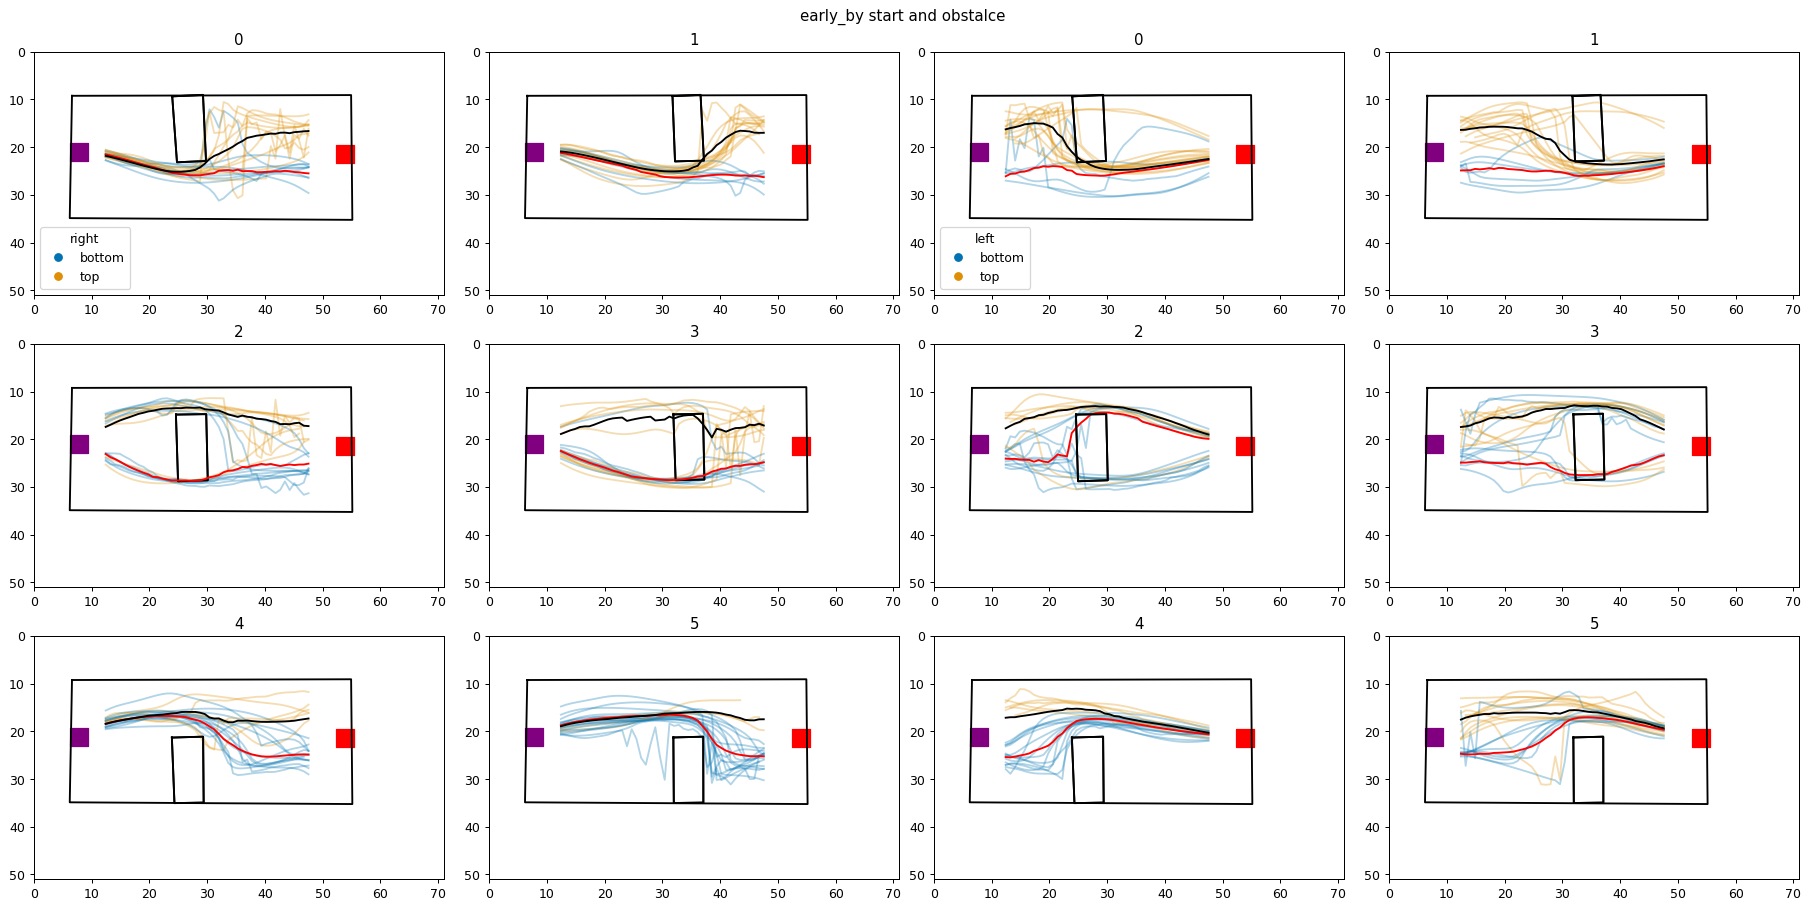

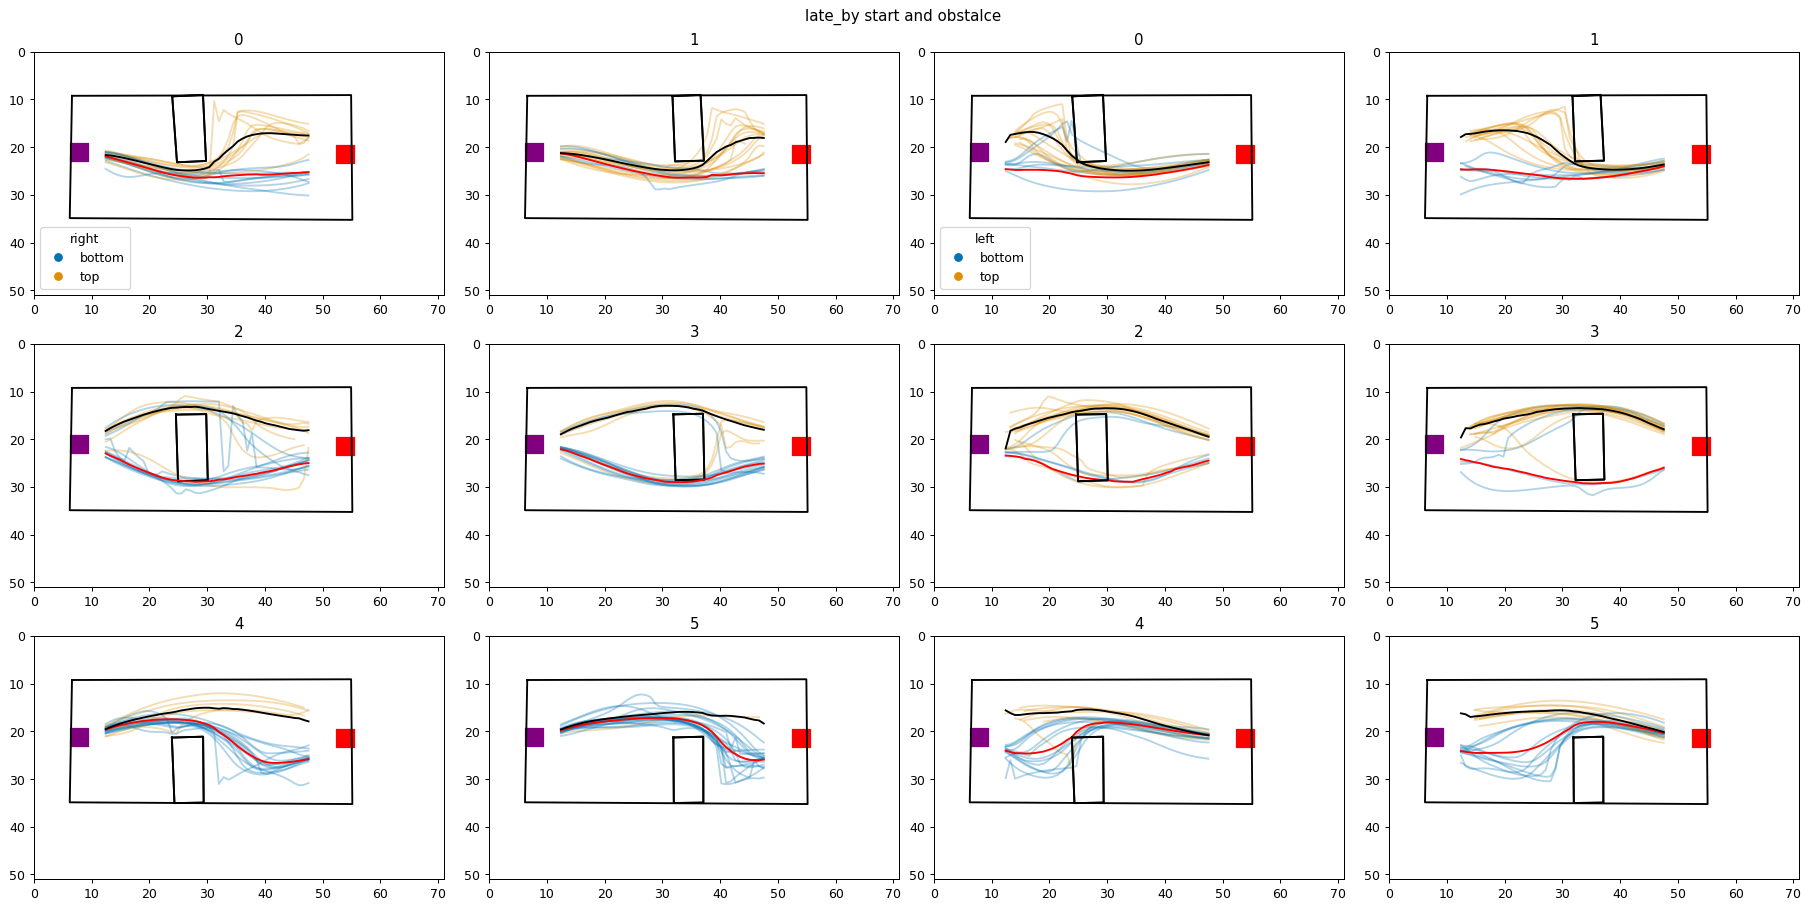

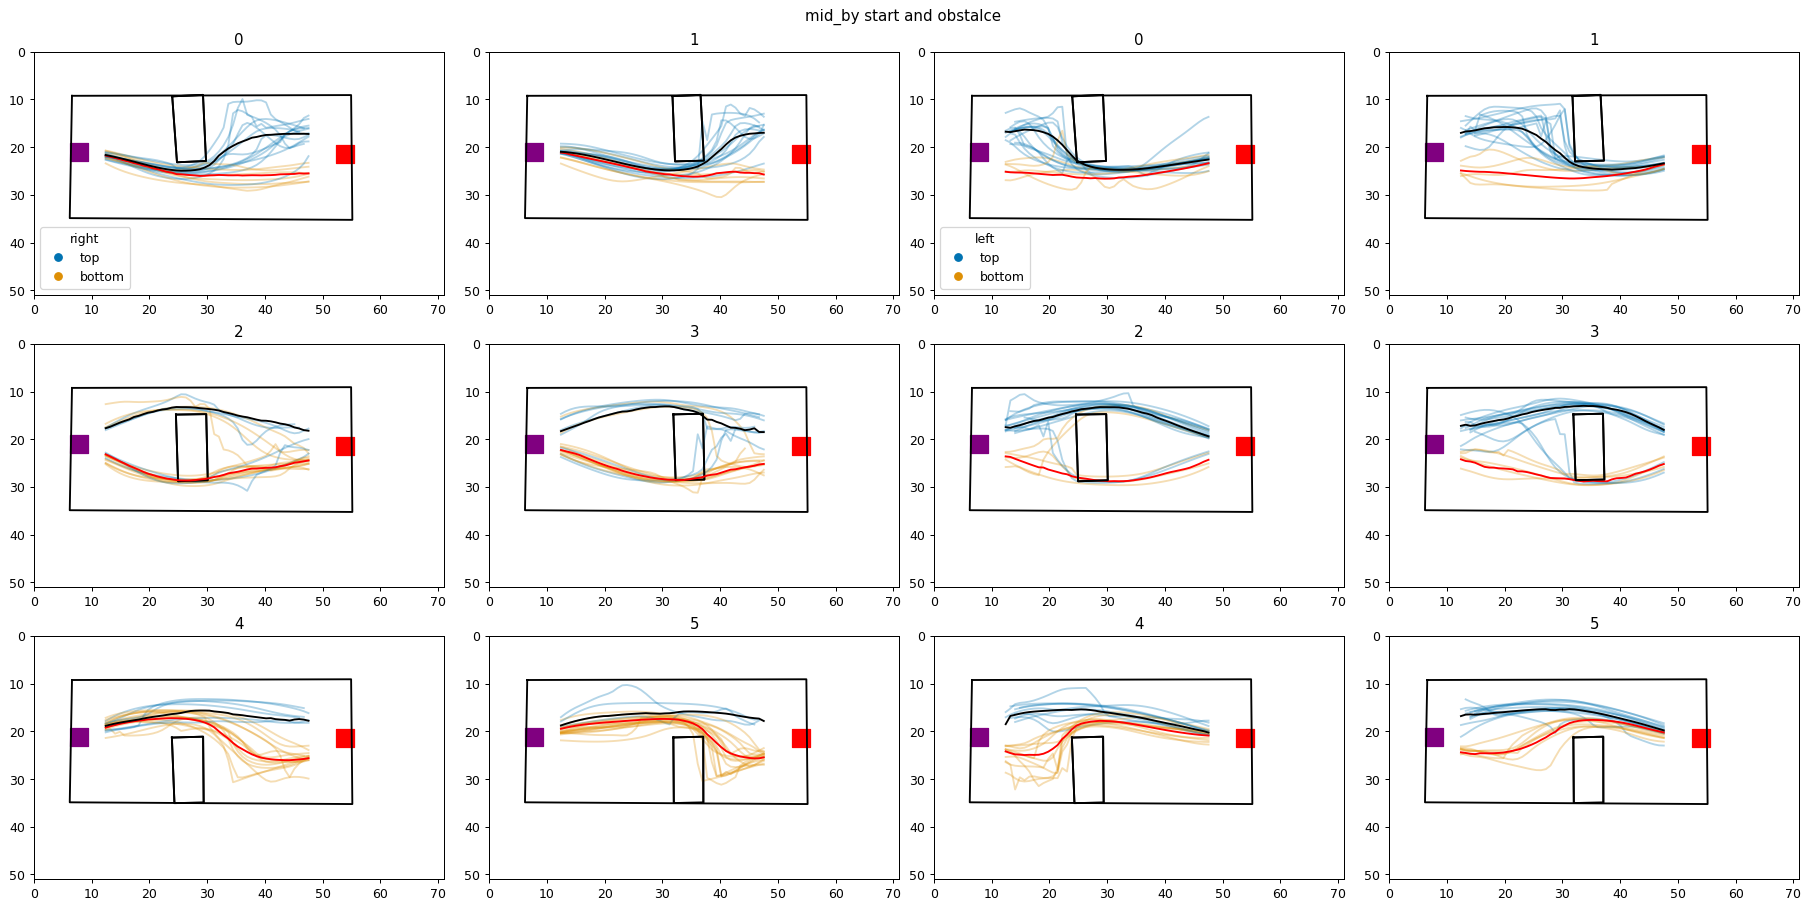

In [662]:
x_basis = np.linspace(10,50,50)
for date,date_frame in session.df.groupby(['exp']):
    #print(pd.unique(date_frame['date']))
    #print(date)


    
    """Calculate interp y which is interpolation of nose_x vs nose_y then ploted against the mean_interp_noseX """
    for ind,row in date_frame.iterrows():
        interp = interp1d(row['ts_nose_x_cm'].astype(float), row['ts_nose_y_cm'].astype(float) ,bounds_error=False)
        interp_y = interp(x_basis)
        #interp_y = interpolate_array(interp_y)
        date_frame.at[ind,'interp_ts_nose_y_cm'] = interp_y.astype(object)
    
    
    
    for direction, direction_frame in date_frame.groupby(['odd']):
        for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
            for start, start_frame in cluster_frame.groupby(['start']):
                array = np.zeros([len(start_frame), 50])
                count = 0
                for ind,row in start_frame.iterrows():
                    array[count,:] = row['interp_ts_nose_y_cm']
                    count += 1
                mean_trace = np.nanmean(array,axis=0)
                mean_trace = interpolate_array(mean_trace)
                median_trace = np.nanmedian(array,axis = 0)
                median_trace = interpolate_array(median_trace)
                x = date_frame.loc[(date_frame['obstacle_cluster'] ==cluster) & (date_frame['start']==start)&(date_frame['odd'] ==direction)]
                for ind,row in x.iterrows():
                    
                    date_frame.at[ind,'median_interp_ts_nose_y_cm']= median_trace.astype(object)
                
                    date_frame.at[ind,'mean_interp_ts_nose_y_cm']= mean_trace.astype(object)
    obstacle_by_variable(date_frame,'start','colorblind',20)



In [616]:
threshold= 0
mask = row['interp_ts_nose_y_cm'] >= session.df.arenaBL_y_cm[0]
sum(mask) 

0

In [611]:
any(i==np.nan for i in row['interp_ts_nose_y_cm'])

False

In [595]:
session.df.arenaBL_y_cm[0]

34.87624206213466

In [617]:
for ind, row in session.df.iterrows():
    if sum(row['interp_ts_nose_y_cm'] >=session.df.arenaBL_y_cm[0])>0:
        print(ind)
    
    if sum(row['interp_ts_nose_y_cm']<=session.df.arenaTL_y_cm[0])>0:
        print(ind)
    

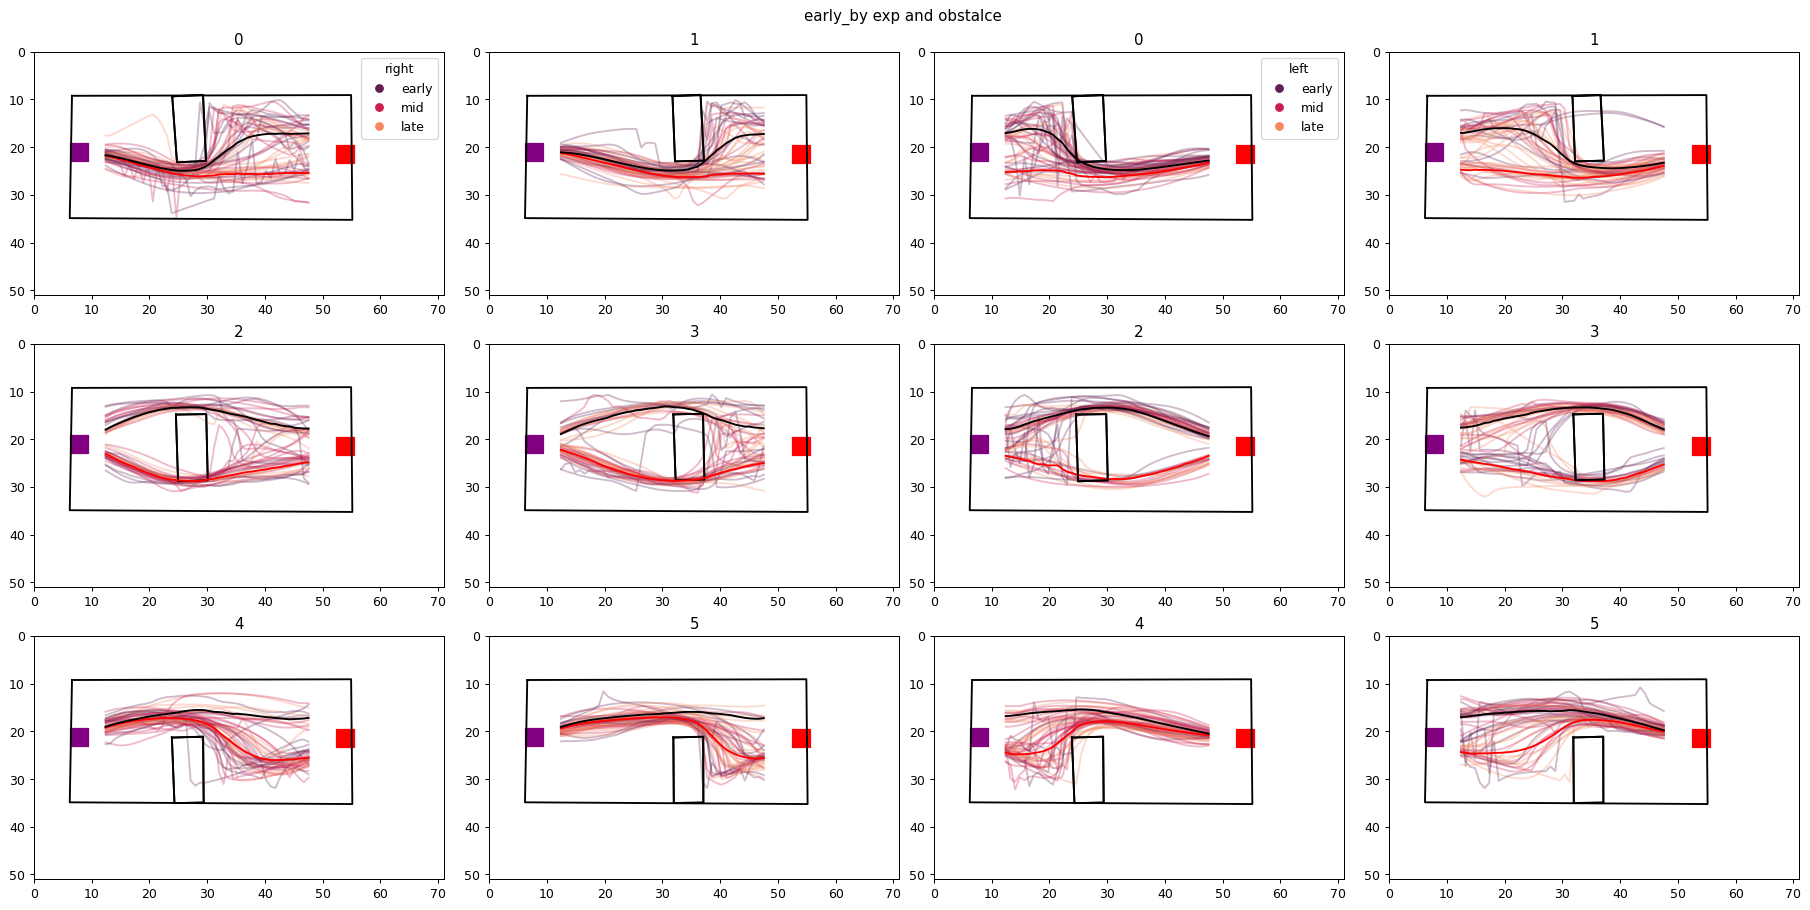

In [663]:
obstacle_by_variable(session.df,'exp','rocket',50)


In [660]:

def get_mean_median_by_variable(df,key): 
    for key_name,frame in df.groupby([str(key)]):
        for direction, direction_frame in frame.groupby(['odd']):
            for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
                for start, start_frame in cluster_frame.groupby(['start']):
                    array = np.zeros([len(start_frame), 50])
                    count = 0
                    for ind,row in start_frame.iterrows():
                        array[count,:] = row['interp_ts_nose_y_cm']
                        count += 1
                    mean_trace = np.nanmean(array,axis=0)
                    median_trace = np.nanmedian(array,axis = 0)
                    x = frame.loc[(frame['obstacle_cluster'] ==cluster) & (frame['start']==start)&(frame['odd'] ==direction)]
                    for ind,row in x.iterrows():

                        df.at[ind,key+'_''median_interp_ts_nose_y_cm']= median_trace.astype(object)

                        df.at[ind,key+'_''mean_interp_ts_nose_y_cm']= mean_trace.astype(object)
        
    

In [694]:
def get_mean_median_by_2_variables(df,key,key1): 
    for key_name,frame in df.groupby([str(key)]):
        for key_name1,frame1 in frame.groupby([str(key1)]):
            for direction, direction_frame in frame1.groupby(['odd']):
                for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
                    for start, start_frame in cluster_frame.groupby(['start']):
                        array = np.zeros([len(start_frame), 50])
                        count = 0
                        for ind,row in start_frame.iterrows():
                            array[count,:] = row['interp_ts_nose_y_cm']
                            count += 1
                        mean_trace = np.nanmean(array,axis=0)
                        median_trace = np.nanmedian(array,axis = 0)
                        x = frame1.loc[(frame1['obstacle_cluster'] ==cluster) & (frame1['start']==start)&(frame1['odd'] ==direction)]
                        for ind,row in x.iterrows():
                        
                            df.at[ind,key+'_'+key1+'_'+'median_interp_ts_nose_y_cm']= median_trace.astype(object)
    
                            df.at[ind,key+'_'+key1+'_'+'mean_interp_ts_nose_y_cm']= mean_trace.astype(object)
            

In [728]:
get_mean_median_by_2_variables(session.df,'exp','animal')

early
late
mid


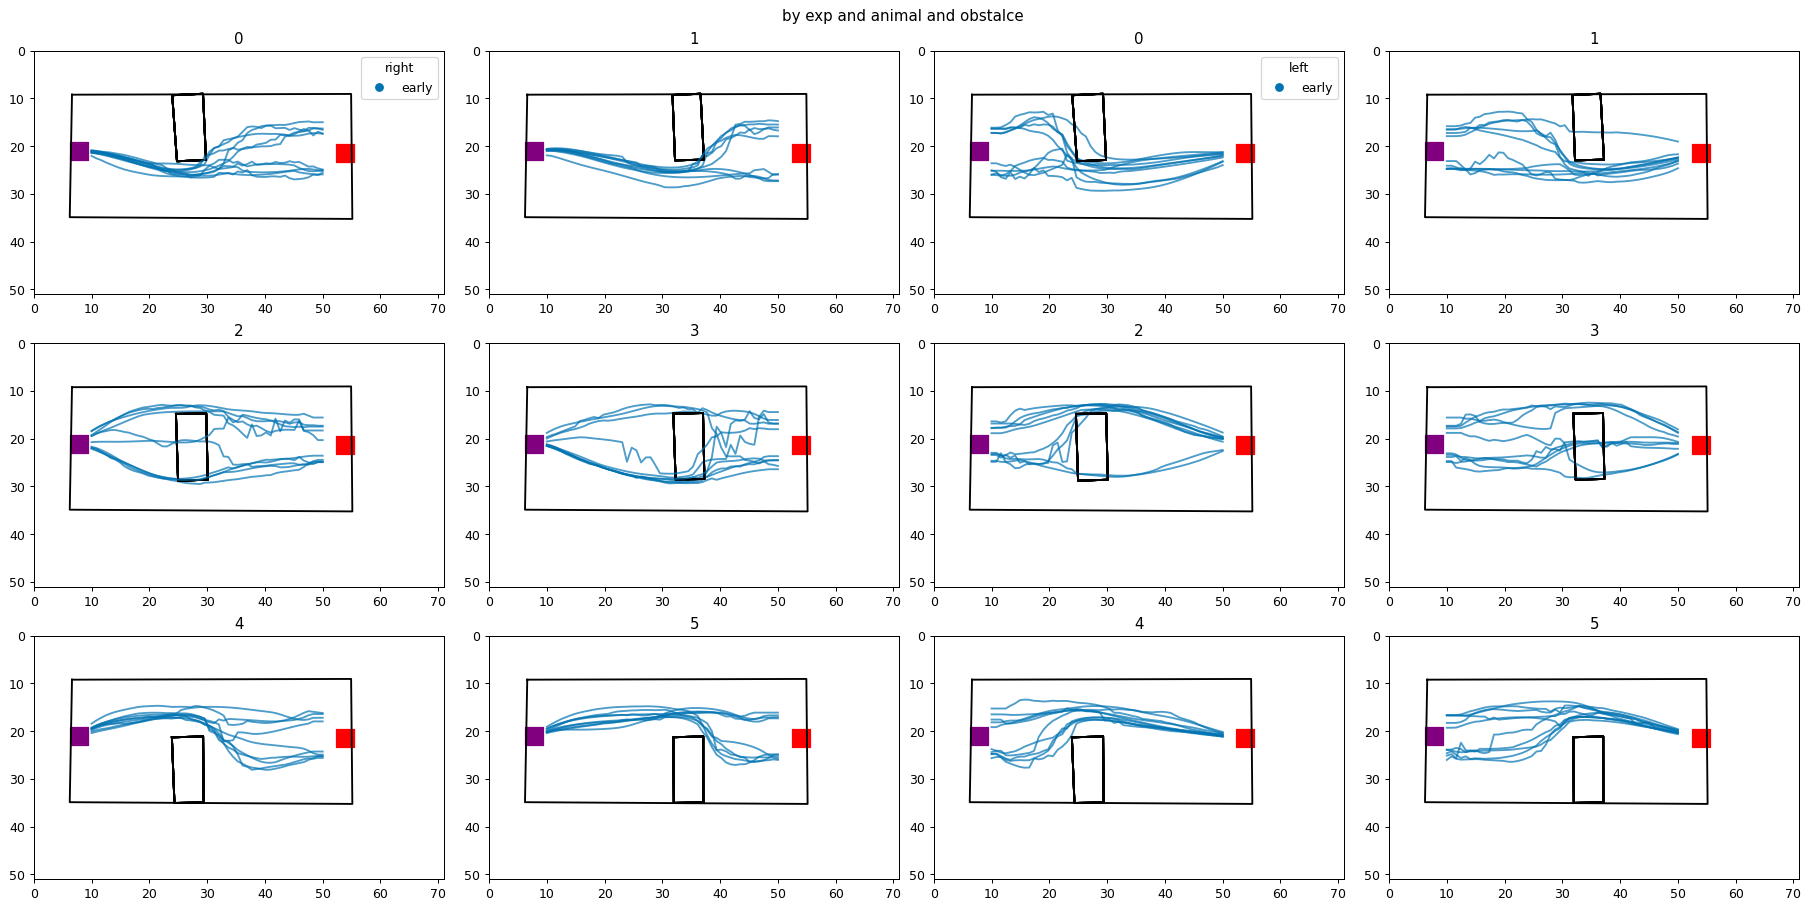

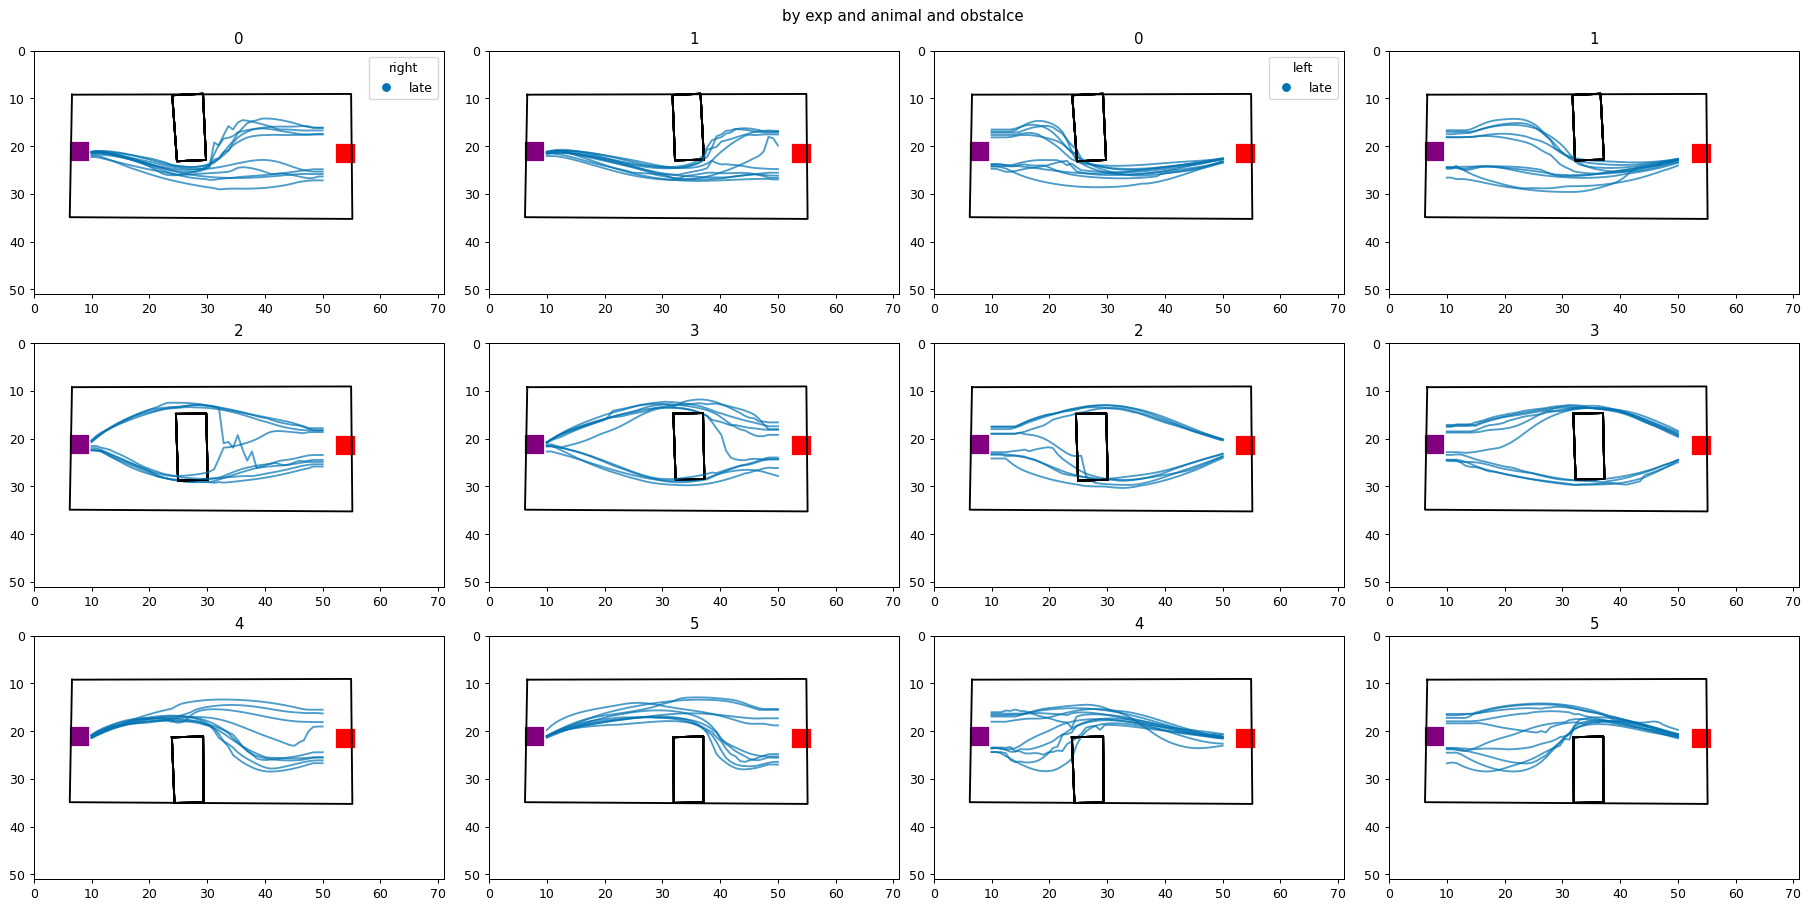

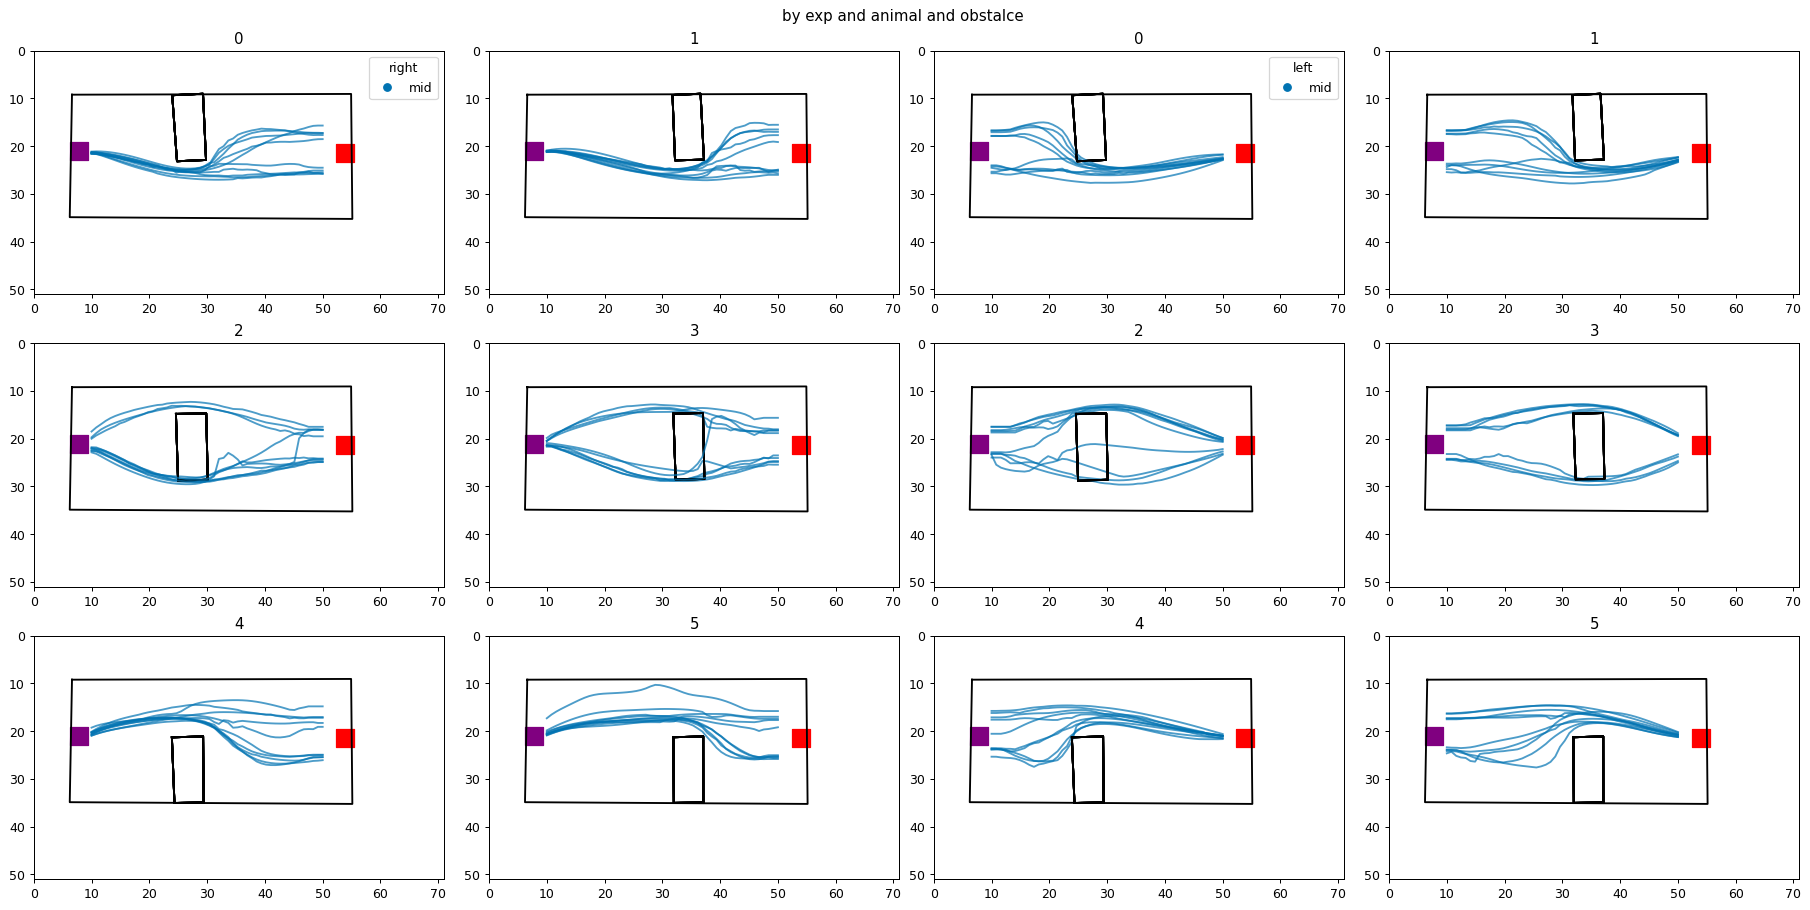

In [736]:
for exp, exp_frame in session.df.groupby(['exp']):
    print(exp)
    mean_variable_obstacle_by_2variable(exp_frame,'exp','animal','exp','colorblind')


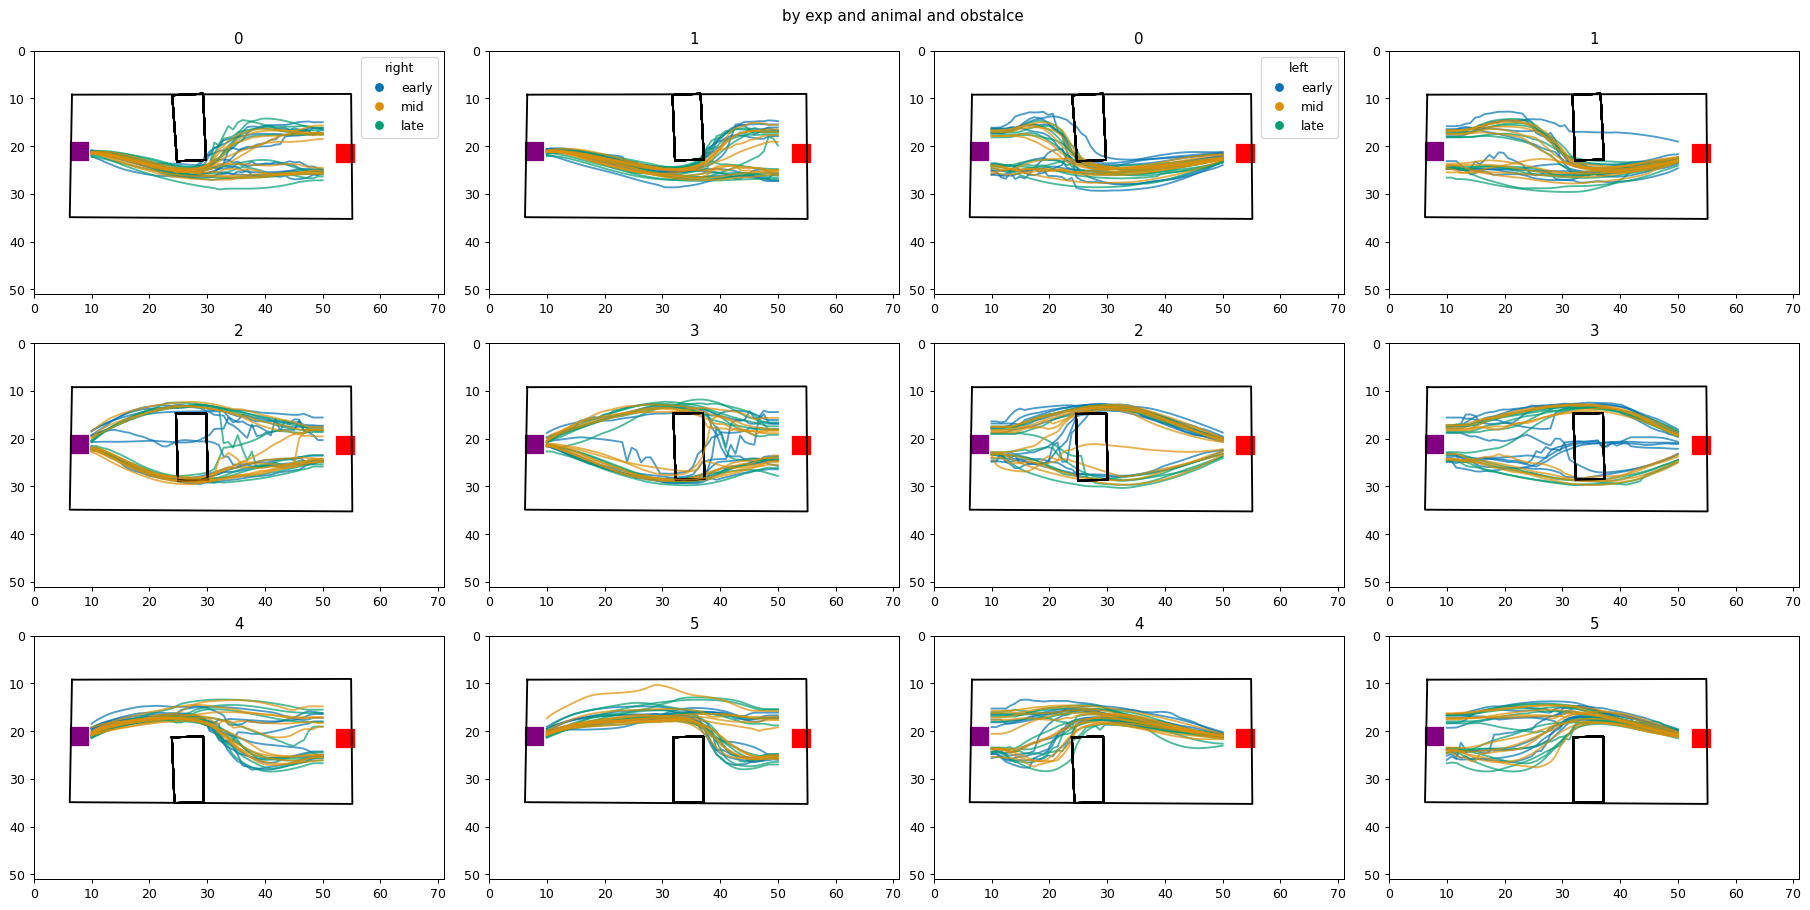

In [737]:
mean_variable_obstacle_by_2variable(session.df,'exp','animal','exp','colorblind')

In [735]:
def mean_variable_obstacle_by_2variable(df,key,key1,color_key,color_pallete):
    """Direction by key obstalce trials"""
    #savepath = "D:/obstacle_avoidance/recordings"
    #savepath_session = os.path.join(*[savepath,'figures'])
    key=key
    x_basis = np.linspace(10,50,50)
    color_pallete = color_pallete
    color_map = create_color_dict(df,color_key,color_pallete)
    #pdf = PdfPages(os.path.join((savepath_session), 'by ' + str(key)+ ' '+ 'and ' +' obstalce.pdf'))
    fig = plt.figure(constrained_layout=False, figsize=(20, 10),dpi=90)

    
    fig.suptitle('by ' + key + ' '+'and'+' '+ key1 + ' '+ 'and ' +'obstalce ')
    spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    """Right"""
    panel_1 = gridspec.GridSpecFromSubplotSpec(3,2,subplot_spec=spec2[0])
    ax1 = fig.add_subplot(panel_1[0,0])
    plot_arena(df,ax1)
    ax2 = fig.add_subplot(panel_1[0,1])
    plot_arena(df,ax2)
    ax2.set_title('right')
    ax3 = fig.add_subplot(panel_1[1,0])
    plot_arena(df,ax3)
    ax4 = fig.add_subplot(panel_1[1,1])
    plot_arena(df,ax4)
    ax5 = fig.add_subplot(panel_1[2,0])
    plot_arena(df,ax5)
    ax6 = fig.add_subplot(panel_1[2,1])
    plot_arena(df,ax6)
    right_axs = [ax1,ax2,ax3,ax4,ax5,ax6]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax1.legend(markers, color_map.keys(), numpoints=1,title = 'right')
    """Left """
    panel_2 = gridspec.GridSpecFromSubplotSpec(3,2,subplot_spec=spec2[1])
    ax7 = fig.add_subplot(panel_2[0,0])
    plot_arena(df,ax7)
    ax8 = fig.add_subplot(panel_2[0,1])
    plot_arena(df,ax8)
    ax8.set_title('left')
    ax9 = fig.add_subplot(panel_2[1,0])
    plot_arena(df,ax9)
    ax10 = fig.add_subplot(panel_2[1,1])
    plot_arena(df,ax10)
    ax11= fig.add_subplot(panel_2[2,0])
    plot_arena(df,ax11)
    ax12 = fig.add_subplot(panel_2[2,1])
    plot_arena(df,ax12)
    left_axs = [ax7,ax8,ax9,ax10,ax11,ax12]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax7.legend(markers, color_map.keys(), numpoints=1,title = 'left')
    """ plot trials"""
    right_obstacle_dict = dict(zip(pd.unique(df['obstacle_cluster'].sort_values().to_list()),right_axs))
    left_obstacle_dict = dict(zip(pd.unique(df['obstacle_cluster'].sort_values().to_list()),left_axs))
    for key_name,frame in df.groupby([str(key)]):
        for key_name1,frame1 in frame.groupby([str(key1)]):
            for direction, direction_frame in frame1.groupby(['odd']):
                for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
                    #cluster_frame = cluster_frame.sample(num_sample)
                    right_obstacle_axis = right_obstacle_dict.get(cluster)
                    left_obstalce_axis = left_obstacle_dict.get(cluster)
                    plot_obstacle(cluster_frame,right_obstacle_axis,cluster)
                    plot_obstacle(cluster_frame,left_obstalce_axis,cluster)
                    right_obstacle_axis.set_title(str(cluster))
                    left_obstalce_axis.set_title(str(cluster))
                    for start, start_frame in cluster_frame.groupby(['start']):
                            #print(start_frame[[key,key1]])
                            color = color_map.get(pd.unique(start_frame[key]).item())


                            
                            if direction == 'right':
                                if cluster in [2,3]:
                                    right_obstacle_axis.plot(x_basis,start_frame[key+'_'+key1+'_'+'median_interp_ts_nose_y_cm'].to_numpy()[0],c = color,alpha = .7)
                                else:
                                    right_obstacle_axis.plot(x_basis,start_frame[key+'_'+key1+'_'+'mean_interp_ts_nose_y_cm'].to_numpy()[0],c = color,alpha = .7)
                                    #right_obstacle_axis.plot(start_frame['mean_interp_ts_nose_x_cm'].to_numpy()[0],start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')
                             
            
                            
                            if direction == 'left':
                               if cluster in [2,3]:
                                   left_obstalce_axis.plot(x_basis,start_frame[key+'_'+key1+'_'+'median_interp_ts_nose_y_cm'].to_numpy()[0],c = color,alpha = .7)
                               else:
                                   left_obstalce_axis.plot(x_basis,start_frame[key+'_'+key1+'_'+'mean_interp_ts_nose_y_cm'].to_numpy()[0],c = color,alpha = .7)

In [14]:
def mean_variable_obstacle_by_variable(df,key,color_pallete):
    """Direction by key obstalce trials"""
    #savepath = "D:/obstacle_avoidance/recordings"
    #savepath_session = os.path.join(*[savepath,'figures'])
    key=key
    x_basis = np.linspace(10,50,50)
    color_pallete = color_pallete
    color_map = create_color_dict(df,key,color_pallete)
    #pdf = PdfPages(os.path.join((savepath_session), 'by ' + str(key)+ ' '+ 'and ' +' obstalce.pdf'))
    fig = plt.figure(constrained_layout=False, figsize=(20, 10),dpi=90)

    
    fig.suptitle('by ' + key + ' '+ 'and ' +'obstalce ')
    spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    """Right"""
    panel_1 = gridspec.GridSpecFromSubplotSpec(3,2,subplot_spec=spec2[0])
    ax1 = fig.add_subplot(panel_1[0,0])
    plot_arena(df,ax1)
    ax2 = fig.add_subplot(panel_1[0,1])
    plot_arena(df,ax2)
    ax2.set_title('right')
    ax3 = fig.add_subplot(panel_1[1,0])
    plot_arena(df,ax3)
    ax4 = fig.add_subplot(panel_1[1,1])
    plot_arena(df,ax4)
    ax5 = fig.add_subplot(panel_1[2,0])
    plot_arena(df,ax5)
    ax6 = fig.add_subplot(panel_1[2,1])
    plot_arena(df,ax6)
    right_axs = [ax1,ax2,ax3,ax4,ax5,ax6]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax1.legend(markers, color_map.keys(), numpoints=1,title = 'right')
    """Left """
    panel_2 = gridspec.GridSpecFromSubplotSpec(3,2,subplot_spec=spec2[1])
    ax7 = fig.add_subplot(panel_2[0,0])
    plot_arena(df,ax7)
    ax8 = fig.add_subplot(panel_2[0,1])
    plot_arena(df,ax8)
    ax8.set_title('left')
    ax9 = fig.add_subplot(panel_2[1,0])
    plot_arena(df,ax9)
    ax10 = fig.add_subplot(panel_2[1,1])
    plot_arena(df,ax10)
    ax11= fig.add_subplot(panel_2[2,0])
    plot_arena(df,ax11)
    ax12 = fig.add_subplot(panel_2[2,1])
    plot_arena(df,ax12)
    left_axs = [ax7,ax8,ax9,ax10,ax11,ax12]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax7.legend(markers, color_map.keys(), numpoints=1,title = 'left')
    """ plot trials"""
    right_obstacle_dict = dict(zip(pd.unique(df['obstacle_cluster'].sort_values().to_list()),right_axs))
    left_obstacle_dict = dict(zip(pd.unique(df['obstacle_cluster'].sort_values().to_list()),left_axs))
    for key_name,frame in df.groupby([str(key)]):
        for direction, direction_frame in frame.groupby(['odd']):
            for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
                #cluster_frame = cluster_frame.sample(num_sample)
                right_obstacle_axis = right_obstacle_dict.get(cluster)
                left_obstalce_axis = left_obstacle_dict.get(cluster)
                plot_obstacle(cluster_frame,right_obstacle_axis,cluster)
                plot_obstacle(cluster_frame,left_obstalce_axis,cluster)
                right_obstacle_axis.set_title(str(cluster))
                left_obstalce_axis.set_title(str(cluster))
                for start, start_frame in cluster_frame.groupby(['start']):
                        color = color_map.get(pd.unique(start_frame[key]).item())
                        
                        if direction == 'right':
                            if cluster in [2,3]:
                                right_obstacle_axis.plot(x_basis,start_frame[key+'_median_interp_ts_nose_y_cm'].to_numpy()[0],c = color)
                            else:
                                right_obstacle_axis.plot(x_basis,start_frame[key+'_mean_interp_ts_nose_y_cm'].to_numpy()[0],c = color)
                                #right_obstacle_axis.plot(start_frame['mean_interp_ts_nose_x_cm'].to_numpy()[0],start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')
                         
        
                        
                        if direction == 'left':
                           if cluster in [2,3]:
                               left_obstalce_axis.plot(x_basis,start_frame[key+'_median_interp_ts_nose_y_cm'].to_numpy()[0],c = color)
                           else:
                               left_obstalce_axis.plot(x_basis,start_frame[key+'_mean_interp_ts_nose_y_cm'].to_numpy()[0],c = color)

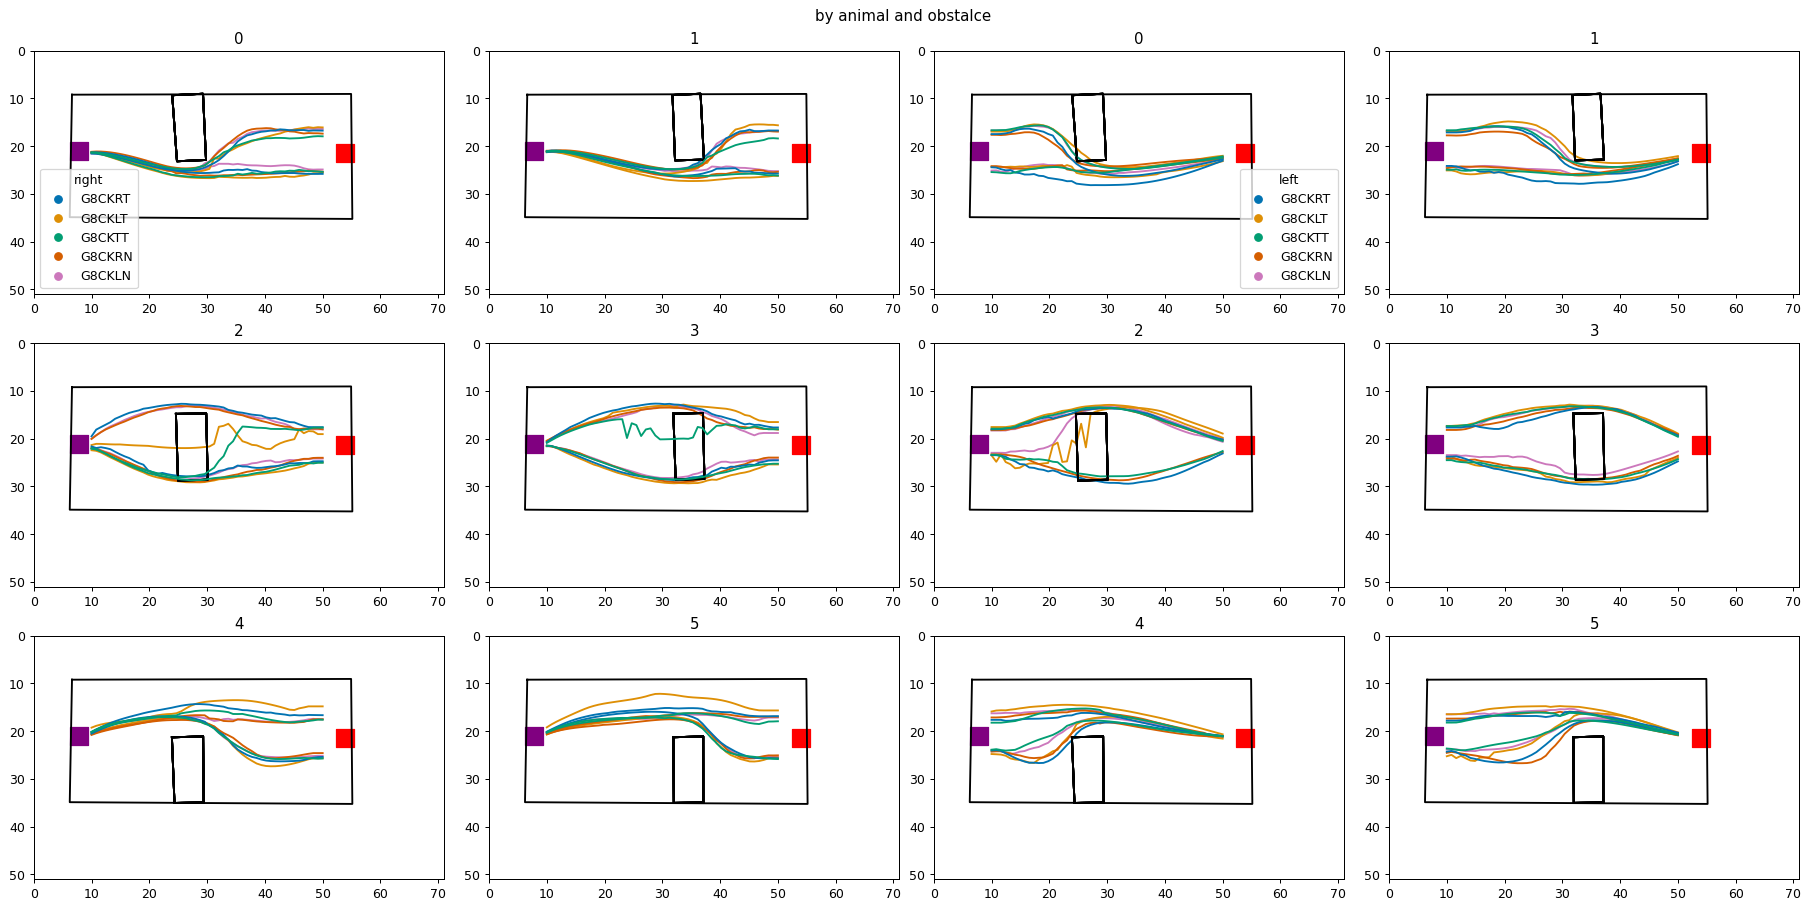

In [15]:
mean_variable_obstacle_by_variable(session.df,'animal','colorblind')

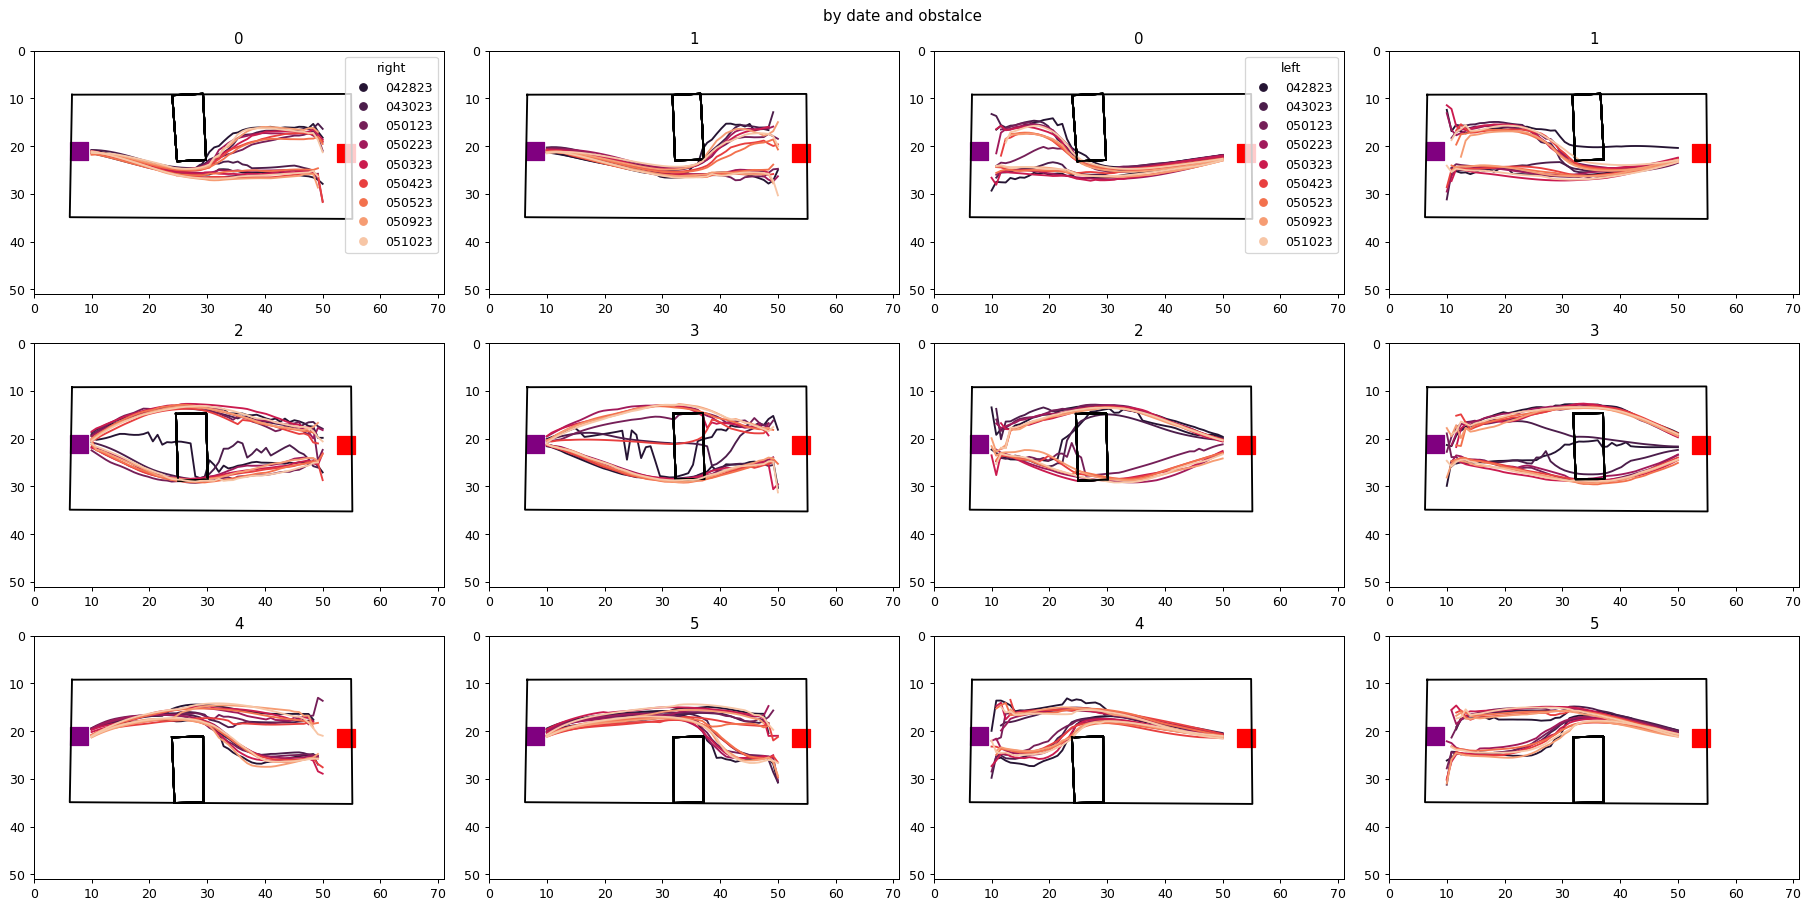

In [309]:
mean_variable_obstacle_by_variable(session.df,'date','date','rocket')

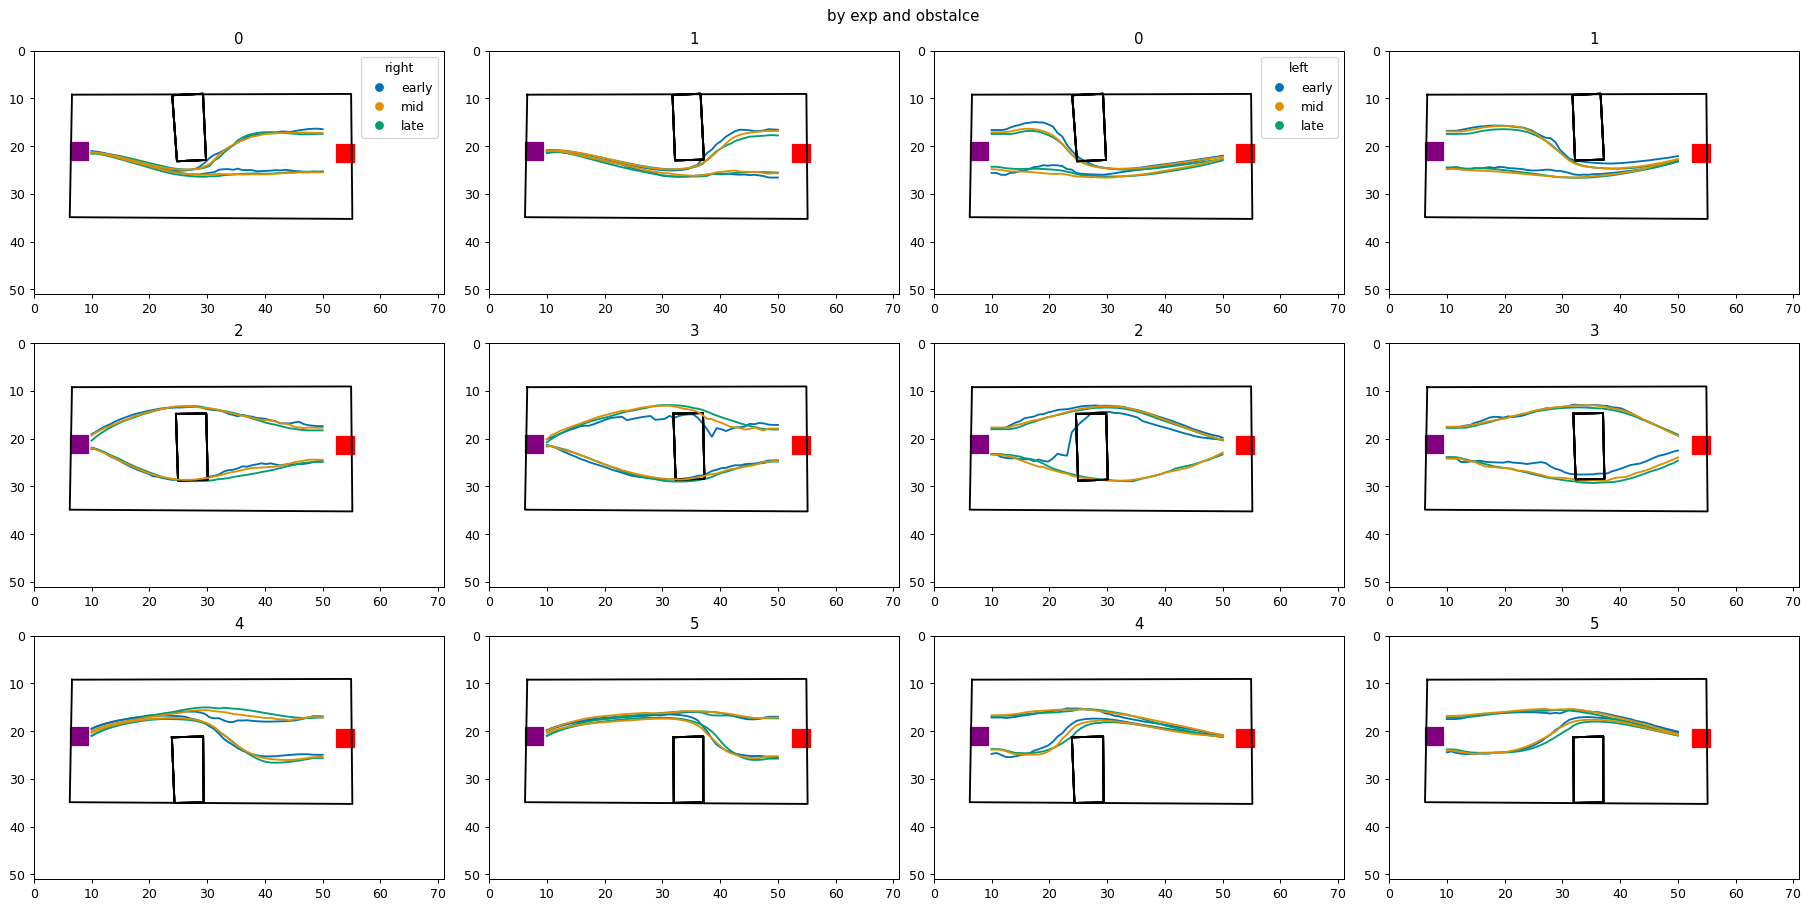

In [716]:
mean_variable_obstacle_by_variable(session.df,'exp','colorblind')

In [ ]:
def plot_each_variable_obstacle_by_start(df,key,color_pallete,num_sample):
    """Direction by key obstalce trials"""
    x_basis = np.linspace(10,50,50)
    #savepath = "D:/obstacle_avoidance/recordings"
    #savepath_session = os.path.join(*[savepath,'figures'])
    key=key
    color_pallete = color_pallete
    color_map = create_color_dict(df,key,color_pallete)
    #pdf = PdfPages(os.path.join((savepath_session), 'by ' + str(key)+ ' '+ 'and ' +' obstalce.pdf'))
    fig = plt.figure(constrained_layout=False, figsize=(20, 10),dpi=90)

    
    fig.suptitle('by ' + key + ' '+ 'and ' +'obstalce ')
    spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    """Right"""
    panel_1 = gridspec.GridSpecFromSubplotSpec(3,2,subplot_spec=spec2[0])
    ax1 = fig.add_subplot(panel_1[0,0])
    plot_arena(df,ax1)
    ax2 = fig.add_subplot(panel_1[0,1])
    plot_arena(df,ax2)
    ax2.set_title('right')
    ax3 = fig.add_subplot(panel_1[1,0])
    plot_arena(df,ax3)
    ax4 = fig.add_subplot(panel_1[1,1])
    plot_arena(df,ax4)
    ax5 = fig.add_subplot(panel_1[2,0])
    plot_arena(df,ax5)
    ax6 = fig.add_subplot(panel_1[2,1])
    plot_arena(df,ax6)
    right_axs = [ax1,ax2,ax3,ax4,ax5,ax6]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax1.legend(markers, color_map.keys(), numpoints=1,title = 'right')
    """Left """
    panel_2 = gridspec.GridSpecFromSubplotSpec(3,2,subplot_spec=spec2[1])
    ax7 = fig.add_subplot(panel_2[0,0])
    plot_arena(df,ax7)
    ax8 = fig.add_subplot(panel_2[0,1])
    plot_arena(df,ax8)
    ax8.set_title('left')
    ax9 = fig.add_subplot(panel_2[1,0])
    plot_arena(df,ax9)
    ax10 = fig.add_subplot(panel_2[1,1])
    plot_arena(df,ax10)
    ax11= fig.add_subplot(panel_2[2,0])
    plot_arena(df,ax11)
    ax12 = fig.add_subplot(panel_2[2,1])
    plot_arena(df,ax12)
    left_axs = [ax7,ax8,ax9,ax10,ax11,ax12]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    ax7.legend(markers, color_map.keys(), numpoints=1,title = 'left')
    """ plot trials"""
    right_obstacle_dict = dict(zip(pd.unique(df['obstacle_cluster'].sort_values().to_list()),right_axs))
    left_obstacle_dict = dict(zip(pd.unique(df['obstacle_cluster'].sort_values().to_list()),left_axs))
    for direction, direction_frame in df.groupby(['odd']):
        for cluster, cluster_frame in direction_frame.groupby(['obstacle_cluster']):
            #cluster_frame = cluster_frame.sample(num_sample)
            right_obstacle_axis = right_obstacle_dict.get(cluster)
            left_obstalce_axis = left_obstacle_dict.get(cluster)
            plot_obstacle(cluster_frame,right_obstacle_axis,cluster)
            plot_obstacle(cluster_frame,left_obstalce_axis,cluster)
            right_obstacle_axis.set_title(str(cluster))
            left_obstalce_axis.set_title(str(cluster))
            for ind,row in cluster_frame.iterrows():
                color = color_map.get(pd.unique(row[key]).item())
                if direction == 'right':
                    which_axis = right_obstacle_dict.get(cluster)
                    which_axis.plot(row['ts_nose_x_cm'],row['ts_nose_y_cm'],c = color)
                if direction == 'left':
                    which_axis = left_obstacle_dict.get(cluster)
                    which_axis.plot(row['ts_nose_x_cm'],row['ts_nose_y_cm'],c = color)
            for start, start_frame in cluster_frame.groupby(['start']):
                    
                    if direction == 'right':
                        if start == 'top':
                            right_obstacle_axis.plot(x_basis,start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0],c = 'black')
                            #right_obstacle_axis.plot(start_frame['mean_interp_ts_nose_x_cm'].to_numpy()[0],start_frame['median_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')
                        if start == 'bottom':
                            right_obstacle_axis.plot(x_basis,start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')
    
                    
                    if direction == 'left':
                        if start == 'top':
                            left_obstalce_axis.plot(x_basis,start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0],c = 'black')
                        if start == 'bottom':
                            left_obstalce_axis.plot(x_basis,start_frame['mean_interp_ts_nose_y_cm'].to_numpy()[0],c = 'red')
    #pdf.savefig(); plt.close()
    #pdf.close()

In [552]:
"""label early, middle, late"""

for ind, row in session.df.iterrows():
    if row['date'] in ['042823','043023','050123']:
        session.df.at[ind,'exp'] = 'early'
    if row['date'] in ['050223','050323','050423']:
        session.df.at[ind,'exp'] = 'mid'
    if row['date'] in ['050523','050923','051023']:
        session.df.at[ind,'exp'] = 'late'
for ind, row in session.df.iterrows():
    if row['date'] in ['042823','043023','050123']:
        session.df.at[ind,'exp'] = 'early'
    if row['date'] in ['050223','050323','050423']:
        session.df.at[ind,'exp'] = 'mid'
    if row['date'] in ['050523','050923','051023']:
        session.df.at[ind,'exp'] = 'late'

In [739]:
session.create_consective_df()

In [762]:
order = ['1st','2nd','3rd'] * 1000

In [765]:
session.con_df['order'] = order

In [766]:
session.con_df['order']

343     1st
344     2nd
345     3rd
346     1st
347     2nd
       ... 
4342    2nd
4343    3rd
4344    1st
4345    2nd
4346    3rd
Name: order, Length: 3000, dtype: object

In [767]:
get_mean_median_by_variable(session.con_df,'order')

In [768]:
session.con_df

index    first_poke   second_poke  \
343       1  53950.560793  53955.750912   
344       2  53955.750912  53958.114393   
345       3  53958.114393  53961.108915   
346       4  53961.108915  53964.852940   
347       6  53978.456947  53981.152294   
...     ...           ...           ...   
4342    211  56176.791718  56178.938214   
4343    212  56178.938214  56181.183078   
4344    213  56181.183078  56183.681817   
4345    214  56183.681817  56185.603020   
4346    215  56185.603020  56188.241216   

                                       trial_timestamps  \
343   [53950.571776, 53950.588467, 53950.605862, 539...   
344   [53955.75703, 53955.773632, 53955.791564, 5395...   
345   [53958.124454, 53958.142169, 53958.15776, 5395...   
346   [53961.125427, 53961.142144, 53961.15927, 5396...   
347   [53978.464729, 53978.481766, 53978.498291, 539...   
...                                                 ...   
4342  [56176.805798, 56176.822694, 56176.839795, 561...   
4343  [56178.939827, 56178.956556, 56178.973644, 561...   
4344  [56181.190604, 56181.208166, 56181.224038, 561...   
4345  [56183.691468, 56183.708825, 56183.724902, 561...   
4346  [56185.60887, 56185.625702, 56185.642227, 5618...   

                                        trial_vidframes  \
343   [[1284, 1285, 1286, 1287, 1288, 1289, 1290, 12...   
344   [1595, 1596, 1597, 1598, 1599, 1600, 1601, 160...   
345   [[1737, 1738, 1739, 1740, 1741, 1742, 1743, 17...   
346   [1917, 1918, 1919, 1920, 1921, 1922, 1923, 192...   
347   [2957, 2958, 2959, 2960, 2961, 2962, 2963, 296...   
...                                                 ...   
4342  [35083, 35084, 35085, 35086, 35087, 35088, 350...   
4343  [[35211, 35212, 35213, 35214, 35215, 35216, 35...   
4344  [35346, 35347, 35348, 35349, 35350, 35351, 353...   
4345  [[35496, 35497, 35498, 35499, 35500, 35501, 35...   
4346  [35611, 35612, 35613, 35614, 35615, 35616, 356...   

                                                 nose_x  \
343   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
344   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
345   [682.2976684570312, 683.12744140625, nan, nan,...   
346   [98.7120132446289, 98.35353088378906, 97.90589...   
347   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
...                                                 ...   
4342  [112.92366027832031, 111.69530487060547, 114.1...   
4343  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4344  [113.5621337890625, 112.67525482177734, 115.17...   
4345  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4346  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                                 nose_y  \
343   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
344   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
345   [274.8915100097656, 275.080078125, nan, nan, n...   
346   [277.3341064453125, 277.6127624511719, 277.443...   
347   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
...                                                 ...   
4342  [277.7599182128906, 277.9961853027344, 279.012...   
4343  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4344  [278.27484130859375, 278.41448974609375, 279.3...   
4345  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4346  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                              leftear_x  \
343   [671.5906982421875, 673.7359619140625, 676.169...   
344   [106.0430908203125, 105.33464813232422, 104.59...   
345   [668.080078125, 670.3260498046875, 672.5081176...   
346   [117.34370422363281, 116.2473373413086, 115.83...   
347   [107.61906433105469, 105.91256713867188, 105.2...   
...                                                 ...   
4342  [133.8013153076172, 131.83428955078125, 129.96...   
4343  [675.6560668945312, 677.0065307617188, 677.658...   
4344  [134.09996032714844, 133.15447998046875, 131.9...   
4345  [675.7291870117188, 677.722900390625, 678.3010...   
4346

In [769]:
 color_map = create_color_dict(session.con_df,'order','colorblind')

In [770]:
color_map

{'1st': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 '2nd': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 '3rd': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

0    [18.308427884430014, 18.308427884430014, 18.28...
1    [21.401359342670727, 21.452327186245817, 21.57...
2    [16.77408128416917, 16.78238749900825, 16.8282...
Name: order_mean_interp_ts_nose_y_cm, dtype: object
0    [23.643856211237143, 23.643856211237143, 23.82...
1    [21.401359342670727, 21.452327186245817, 21.57...
2    [16.77408128416917, 16.78238749900825, 16.8282...
Name: order_mean_interp_ts_nose_y_cm, dtype: object
0    [21.416927026376133, 21.502048757002957, 21.69...
1    [16.880981671545893, 16.880981671545893, 16.88...
2    [21.420059593407895, 21.43546816330293, 21.534...
Name: order_mean_interp_ts_nose_y_cm, dtype: object
0    [21.335672646914336, 21.35241333376848, 21.448...
1    [25.48954744016729, 25.562067412556434, 25.710...
2    [21.420059593407895, 21.43546816330293, 21.534...
Name: order_mean_interp_ts_nose_y_cm, dtype: object
0    [21.416927026376133, 21.502048757002957, 21.69...
1    [16.880981671545893, 16.880981671545893, 16.88...
2    [21.4200595934078

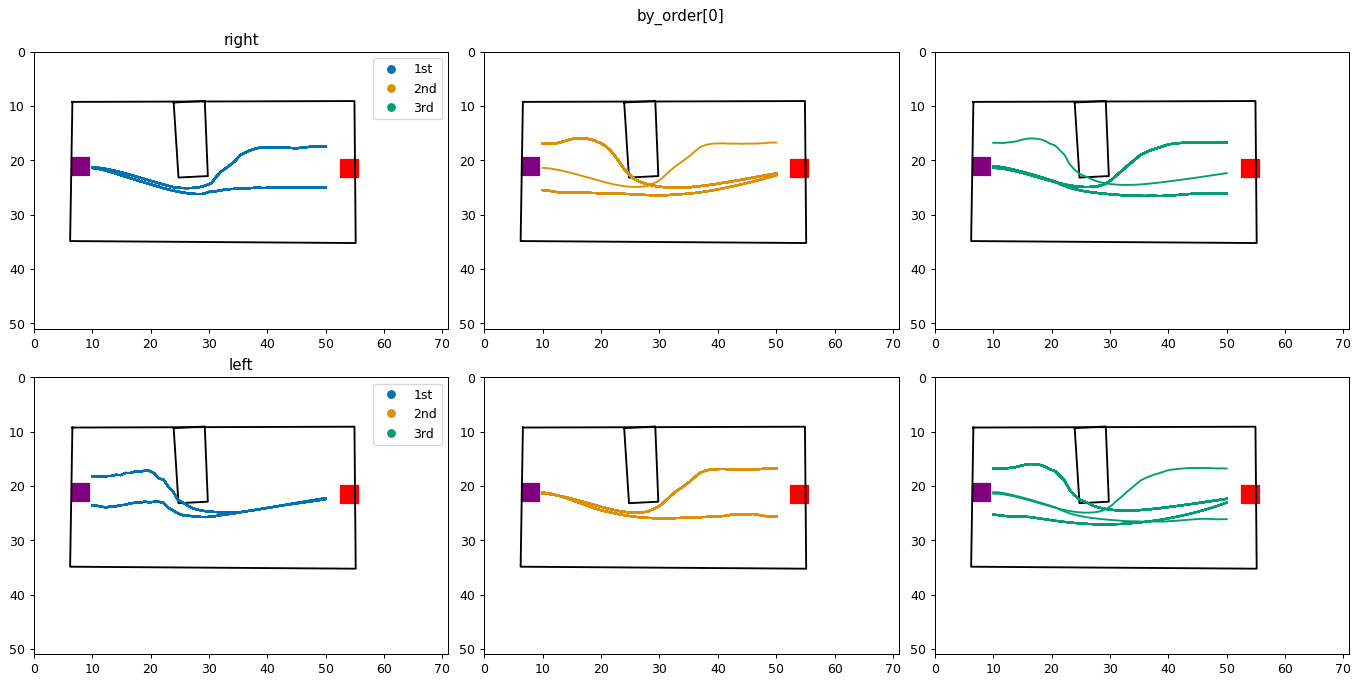

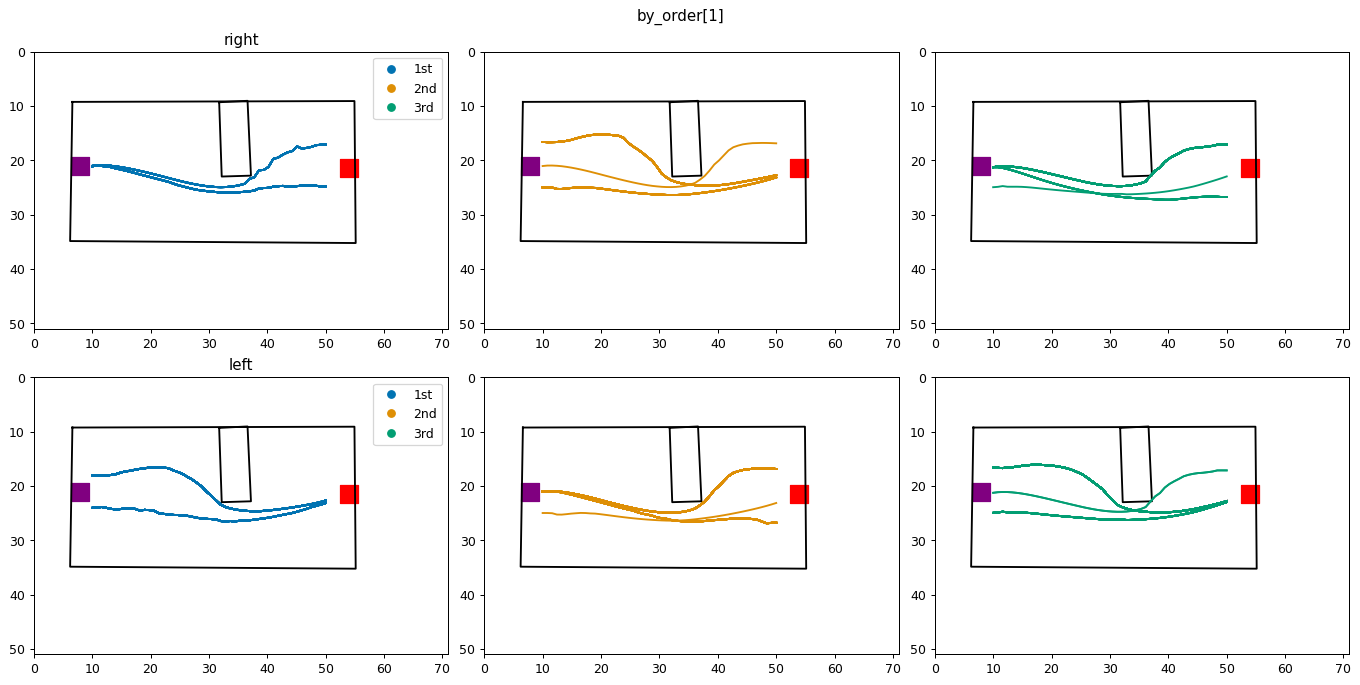

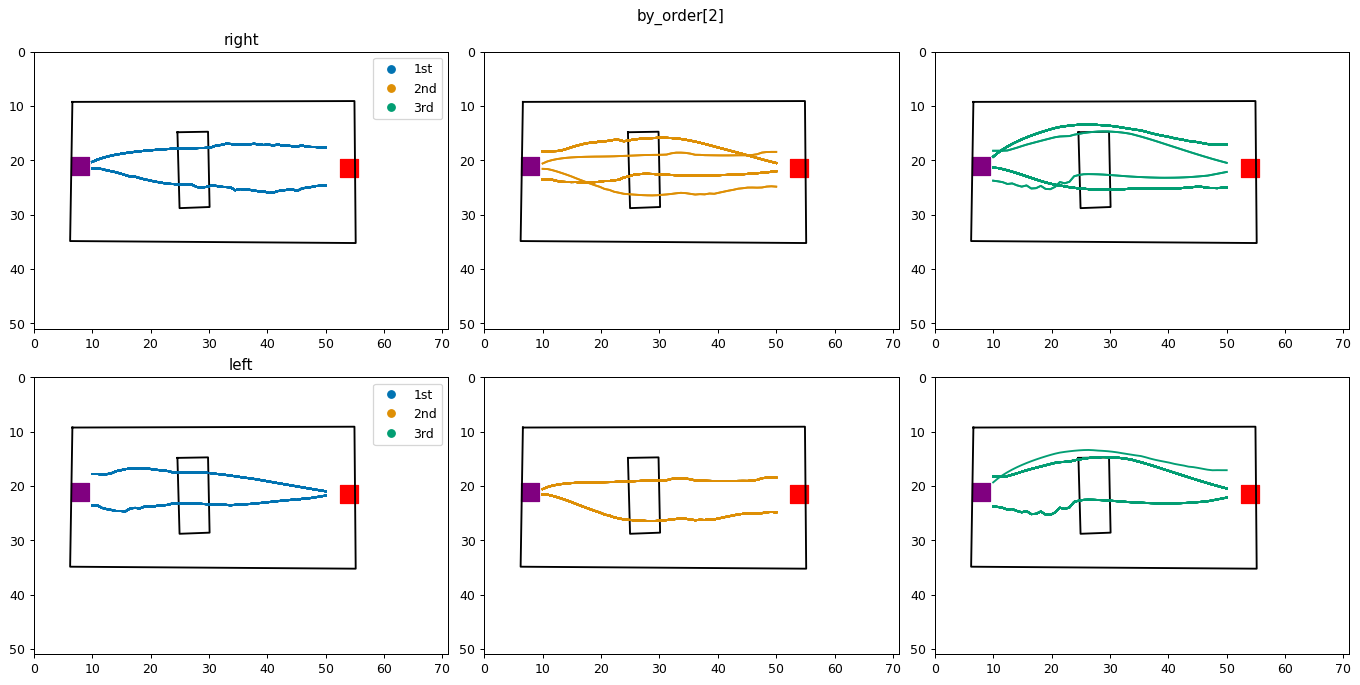

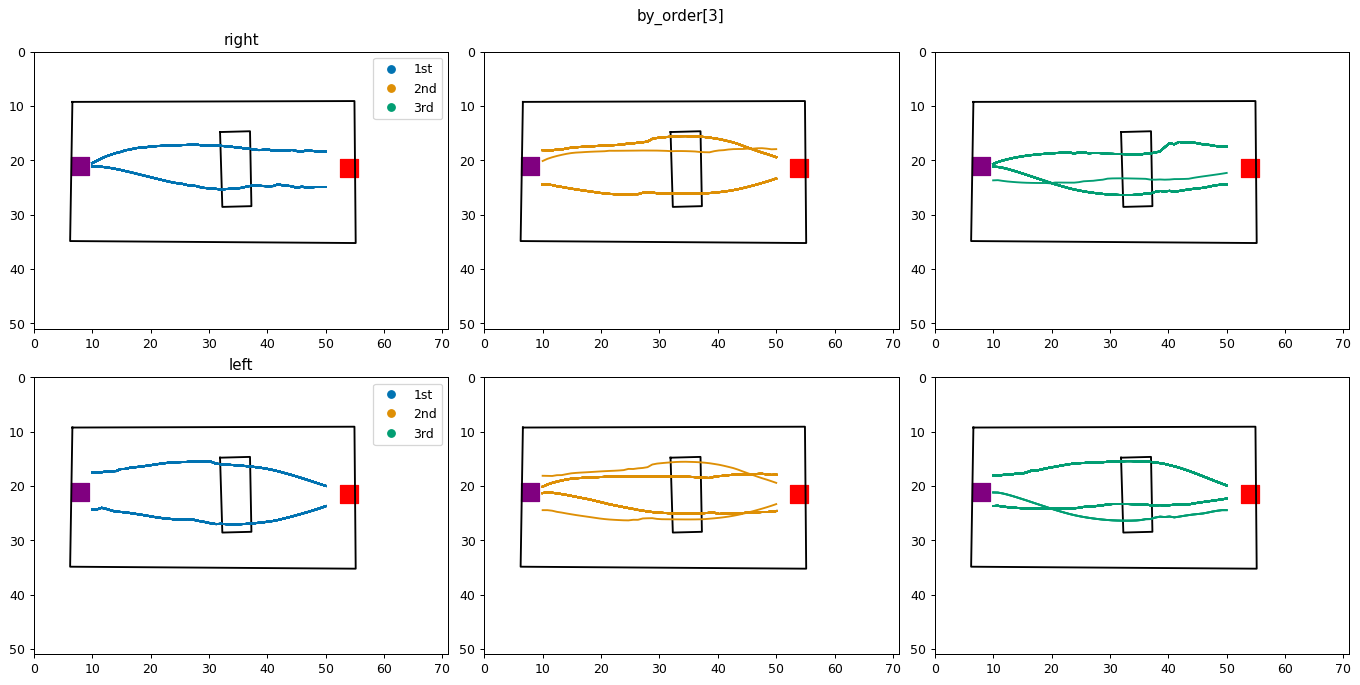

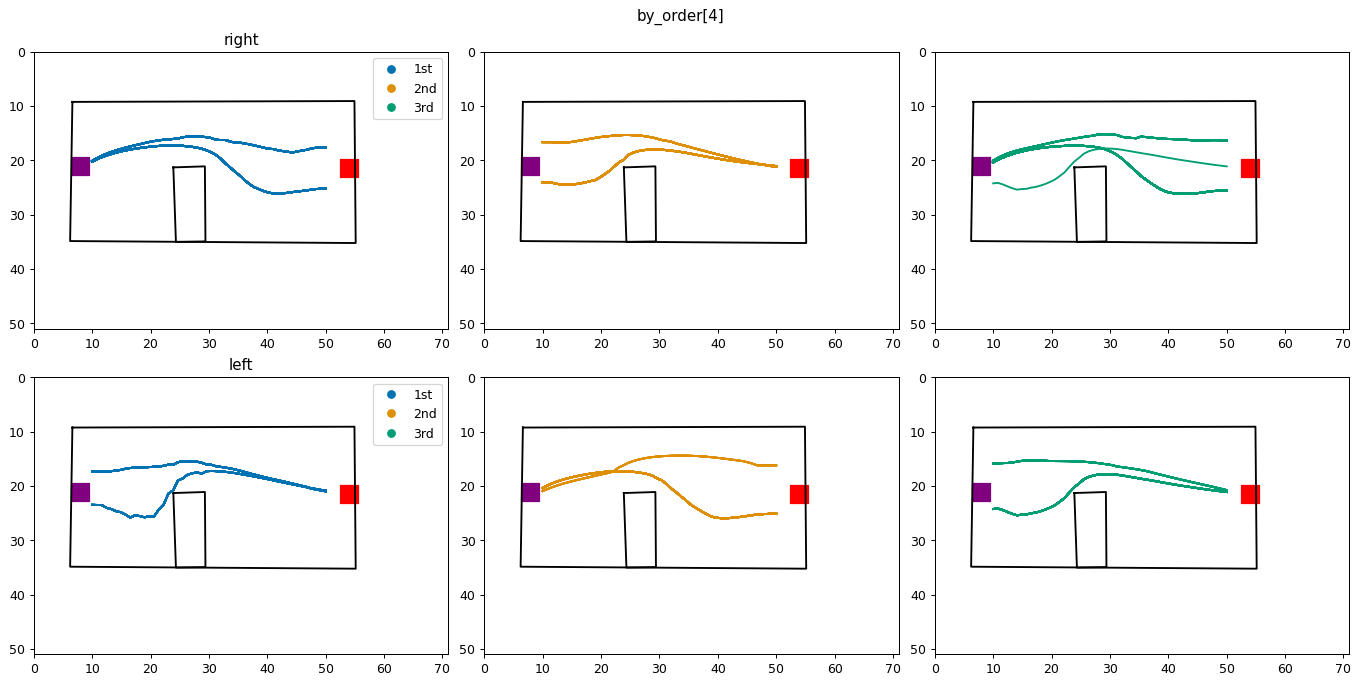

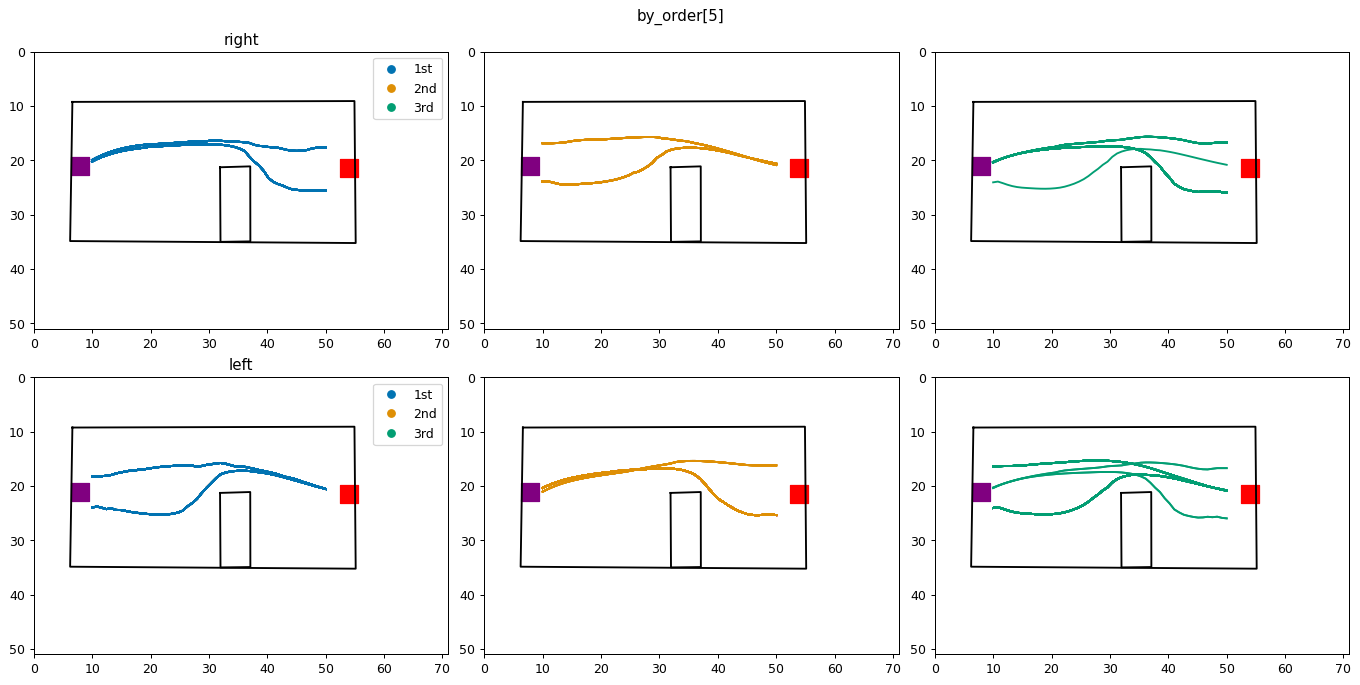

In [786]:
plot_mean_consective_trials(session.con_df,'order','colorblind')

In [785]:
def plot_mean_consective_trials(df,key,color_pallete):
        """consecutive plots"""
        x_basis = np.linspace(10,50,50)


        #savepath = "D:/obstacle_avoidance/recordings"
        #savepath_session = os.path.join(*[savepath,'figures'])
        key = key
        color_pallete = color_pallete
        color_map = create_color_dict(df,key,color_pallete)
        #pdf = PdfPages(os.path.join((savepath_session), 'by_' + str(key)+ '_' 'consecutive.pdf')
        for obstacle, obstalce_frame in df.groupby('obstacle_cluster'):

            df = obstalce_frame
            df = df.reset_index(drop=True)
            fig = plt.figure(constrained_layout=False, figsize=(15, 7.5),dpi=90)
            fig.suptitle('by_' + str(key) + str(pd.unique(df['obstacle_cluster'])))
            spec2 = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)
            #panel_1 = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec=spec2[0])


            """Top Row"""
            ax1 = fig.add_subplot(spec2[0,0])
            ax1.set_title('right')
            plot_arena(df,ax1,obstacle=True)
            ax2 = fig.add_subplot(spec2[0,1])
            plot_arena(df,ax2,obstacle=True)
            ax3 = fig.add_subplot(spec2[0,2])
            plot_arena(df,ax3,obstacle=True)



            """Bottom Row"""
            ax4 = fig.add_subplot(spec2[1,0])
            ax4.set_title('left')
            plot_arena(df,ax4,obstacle=True)
            ax5 = fig.add_subplot(spec2[1,1])
            plot_arena(df,ax5,obstacle=True)
            ax6 = fig.add_subplot(spec2[1,2])
            plot_arena(df,ax6,obstacle=True)



            """Loop through data frame"""
            for key_label,key_frame in obstalce_frame.groupby(key):
                
            
                if key_label = '1st':
                    

            
            #trial_list = list(range(0,len(df),3))
            #trial_list = create_sublists(trial_list)
            ##trial_list = sample(trial_list,100)
            #for sublist in trial_list:
            #    trial = df.iloc[sublist[0]:sublist[1]]
            #    trial = trial.reset_index(drop=True)
            #    print(trial.order_mean_interp_ts_nose_y_cm)
            #    #color = color_map.get(pd.unique(trial[key]).item())
            #    if trial.at[0,'odd'] == 'right':
            #        ax1.plot(x_basis,trial.at[0,'order_mean_interp_ts_nose_y_cm'],c=color_map.get(trial.at[0,key]))
            #        markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
            #        ax1.legend(markers, color_map.keys(), numpoints=1)
            #        ax2.plot(x_basis,trial.at[1,'order_mean_interp_ts_nose_y_cm'],c=color_map.get(trial.at[1,key]))
            #        ax3.plot(x_basis,trial.at[2,'order_mean_interp_ts_nose_y_cm'],c=color_map.get(trial.at[2,key]))
            #    if trial.at[0,'odd'] == 'left':
            #        ax4.plot(x_basis,trial.at[0,'order_mean_interp_ts_nose_y_cm'],c=color_map.get(trial.at[0,key]))
            #        markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
            #        ax4.legend(markers, color_map.keys(), numpoints=1)
            #        ax5.plot(x_basis,trial.at[1,'order_mean_interp_ts_nose_y_cm'],c=color_map.get(trial.at[1,key]))
            #        ax6.plot(x_basis,trial.at[2,'order_mean_interp_ts_nose_y_cm'],c=color_map.get(trial.at[2,key]))
      #


In [750]:
session.con_df[['orginal_index','obstacle_cluster']]

orginal_index  obstacle_cluster
343               1                 2
344               2                 2
345               3                 2
346               4                 1
347               6                 1
...             ...               ...
4342            211                 4
4343            212                 4
4344            213                 2
4345            214                 2
4346            215                 2

[3000 rows x 2 columns]

In [743]:
con_list = session.con_df.orginal_index.to_numpy()

In [744]:
con_list[:100]

array([  1,   2,   3,   4,   6,   7,   8,   9,  11,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  40,  41,  42,  43,  44,  45,  52,  53,
        54,  58,  59,  60,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        89,  90,  91,   1,   2,   3,   4,   5,   6,   7,   8,   9,  13,
        14,  15,  16,  17,  18,  22,  23,  24,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  83,  84,  85,  86,  87,  88,  98,
        99, 100,   5,   6,   7,   8,   9,  10,  11], dtype=int64)

In [ ]:
""" interpolate nose x and nose y"""
"""calculate interp traces"""
for ind, row in self.df.iterrows():

    intx = interp1d(row['ts_nose_x_cm'], row['ts_nose_7_cm'], bounds_error=False,fill_value= 'extrapolate')(fake_time).astype(object)
   
    self.df.at[ind,'interp_ts_nose_x_cm'] = intx.astype(object)
    self.df.at[ind,'interp_ts_nose_y_cm'] = inty.astype(object)

In [186]:
def speed(df):
    time = float(1/60)
    for ind, row in df.iterrows():
        speed = calculate_speed(row['ts_nose_x_cm'],row['ts_nose_y_cm'],time)
        df.at[ind,'speed'] = speed.astype(object)
        

In [187]:
speed(df)

In [199]:
for ind, row in df.iterrows():
    df.at[ind,'len_speed'] = len(row['speed'])
    df.at[ind,'std_speed'] = np.nanstd(row['speed'])
    df.at[ind,'mean_speed'] = np.nanmean(row['speed'])
    df.at[ind,'median_speed'] = np.nanmedian(row['speed'])

In [195]:
np.nanstd(row['speed'])

11.89551305622593

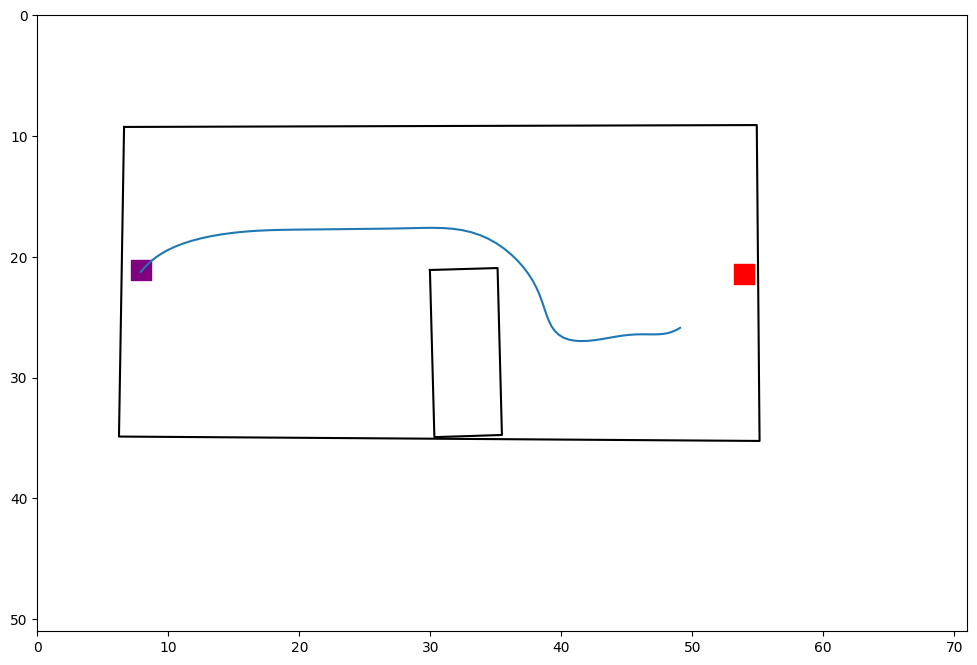

In [294]:
#test = session.df.sample(1)
#angle_to_edges(test)
#get_angle_to_ports(test)

x = interpolate_array(test.ts_nose_x_cm.item()).tolist()
y = interpolate_array(test.ts_nose_y_cm.item()).tolist()
time = float(1/60)
speed = calculate_speed(x,y,time)
speed = np.append(speed,speed[-1])
color_list = []

for val in speed:
    if 0 <= val <= 20:
        color_list.append('b')
    if 20 <= val <= 40:
        color_list.append('g')
    if 40 <= val <= 60:
        color_list.append('r')
    if val > 60:
        color_list.append('c')
points = np.array([x, y]).T.reshape(-1, 1, 2)
fig, ax = plt.subplots(figsize=(12, 8))
plot_single_trial(test,ax,test['obstacle_cluster'].item())
colored_lines = LineCollection(points,colors = color_list, linewidths=(2,))
ax.add_collection(colored_lines)




